In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [16]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', chunk_size=5):
        super(FirstDerivativeLoss, self).__init__()
        self.chunk_size = chunk_size

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), self.chunk_size, -1))
        target_o = torch.reshape(target, (len(target), self.chunk_size, -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [17]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)

    total_loss = imu_loss + d1_loss
    return total_loss, imu_loss, mag_loss, d1_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [18]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = front_pocket_pair_data[:front_pocket_half] #+ pocket_pair_data[:pocket_half] + swing_pair_data[:swing_half]
valid_data = front_pocket_pair_data[front_pocket_half:] #+ pocket_pair_data[pocket_half:] + swing_pair_data[swing_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [19]:
batch = next(iter(train_loader))

In [20]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss(chunk_size=chunk_size)

In [21]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [22]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), self.chunk_size, -1))
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = h_mag.reshape((len(source_mag), self.chunk_size, -1))
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), self.chunk_size, self.seq_len, -1))
        z_imu = self.nn(z_imu)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), self.chunk_size, self.seq_len, -1))
        pred_mag = self.mag_last(pred_mag)
        
        
        return z_imu, pred_mag
        

In [23]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [24]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [25]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [26]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :, :6]
        target_mag = target_data[:, :, :, 6:9]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [27]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

00019: train loss:  857.979, imu loss:  0.670, mag loss:  618.417, div loss:  857.308
       valid loss:  525.893, imu loss:  0.544, mag loss:  634.296, div loss:  525.349
00039: train loss:  816.256, imu loss:  0.647, mag loss:  608.931, div loss:  815.609
       valid loss:  520.668, imu loss:  0.534, mag loss:  629.999, div loss:  520.134
00059: train loss:  859.062, imu loss:  0.609, mag loss:  603.475, div loss:  858.453
       valid loss:  516.021, imu loss:  0.530, mag loss:  625.497, div loss:  515.491
00079: train loss:  855.261, imu loss:  0.611, mag loss:  597.931, div loss:  854.650
       valid loss:  512.409, imu loss:  0.528, mag loss:  619.603, div loss:  511.881
00099: train loss:  862.793, imu loss:  0.620, mag loss:  593.167, div loss:  862.174
       valid loss:  510.065, imu loss:  0.526, mag loss:  618.655, div loss:  509.539
00119: train loss:  790.193, imu loss:  0.633, mag loss:  594.096, div loss:  789.560
       valid loss:  509.215, imu loss:  0.525, mag los

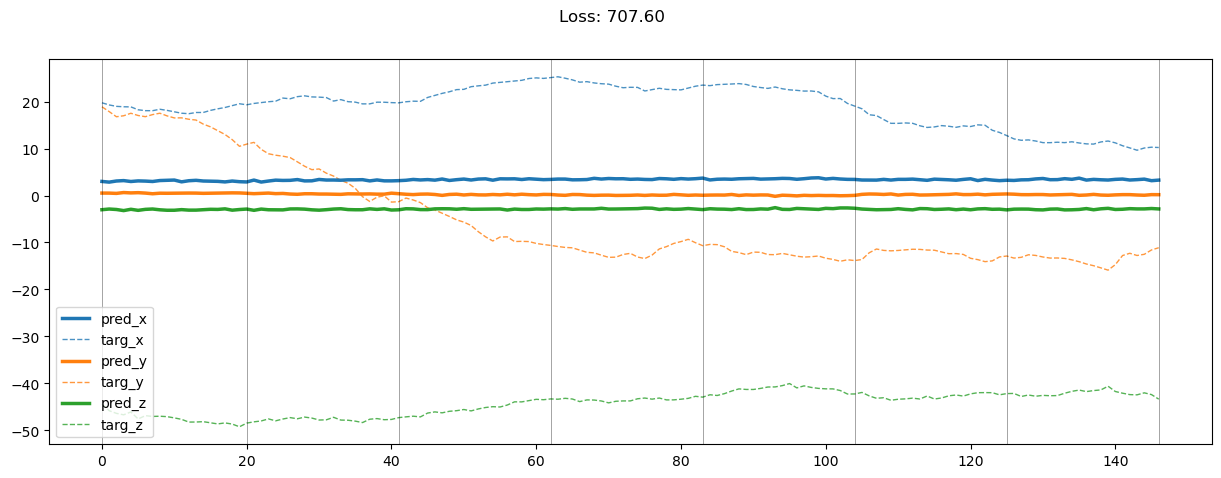

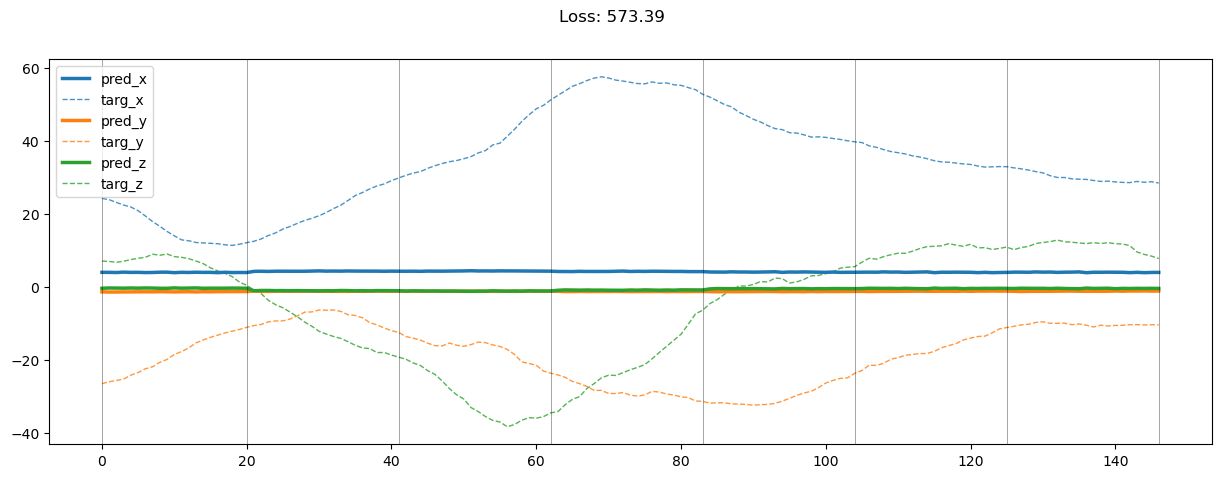

00199: train loss:  792.672, imu loss:  0.611, mag loss:  570.968, div loss:  792.060
       valid loss:  493.241, imu loss:  0.524, mag loss:  594.300, div loss:  492.717
00219: train loss:  812.015, imu loss:  0.647, mag loss:  565.063, div loss:  811.368
       valid loss:  484.803, imu loss:  0.524, mag loss:  589.719, div loss:  484.280
00239: train loss:  769.439, imu loss:  0.648, mag loss:  575.070, div loss:  768.791
       valid loss:  481.132, imu loss:  0.523, mag loss:  583.876, div loss:  480.609
00259: train loss:  737.581, imu loss:  0.636, mag loss:  572.364, div loss:  736.945
       valid loss:  475.660, imu loss:  0.523, mag loss:  579.396, div loss:  475.136
00279: train loss:  745.307, imu loss:  0.630, mag loss:  558.477, div loss:  744.677
       valid loss:  471.830, imu loss:  0.523, mag loss:  572.974, div loss:  471.307
00299: train loss:  730.363, imu loss:  0.621, mag loss:  540.393, div loss:  729.742
       valid loss:  470.131, imu loss:  0.523, mag los

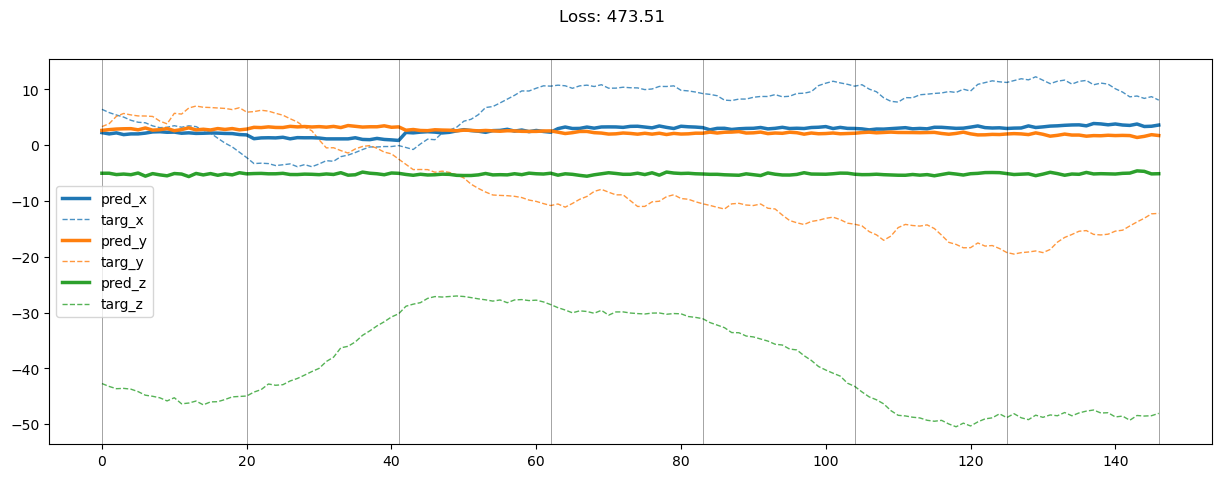

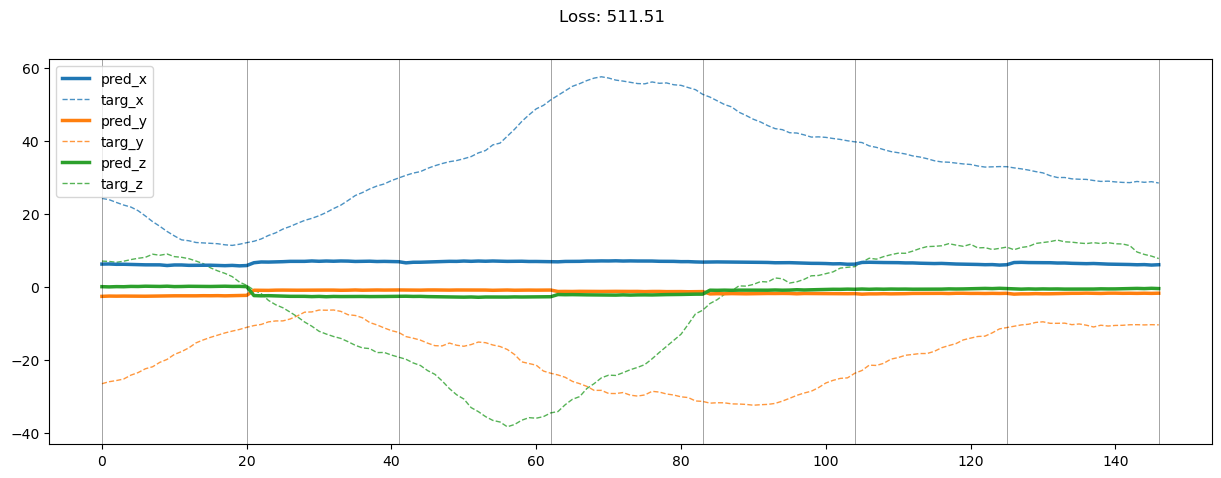

00399: train loss:  709.711, imu loss:  0.611, mag loss:  517.456, div loss:  709.100
       valid loss:  444.681, imu loss:  0.523, mag loss:  537.221, div loss:  444.158
00419: train loss:  708.750, imu loss:  0.632, mag loss:  539.478, div loss:  708.118
       valid loss:  454.614, imu loss:  0.523, mag loss:  546.957, div loss:  454.090
00439: train loss:  629.896, imu loss:  0.624, mag loss:  494.299, div loss:  629.272
       valid loss:  437.664, imu loss:  0.523, mag loss:  527.066, div loss:  437.140
00459: train loss:  665.372, imu loss:  0.588, mag loss:  495.841, div loss:  664.785
       valid loss:  433.817, imu loss:  0.523, mag loss:  521.320, div loss:  433.294
00479: train loss:  597.741, imu loss:  0.643, mag loss:  493.308, div loss:  597.098
       valid loss:  426.617, imu loss:  0.523, mag loss:  514.119, div loss:  426.094
00499: train loss:  652.345, imu loss:  0.636, mag loss:  481.084, div loss:  651.709
       valid loss:  420.417, imu loss:  0.523, mag los

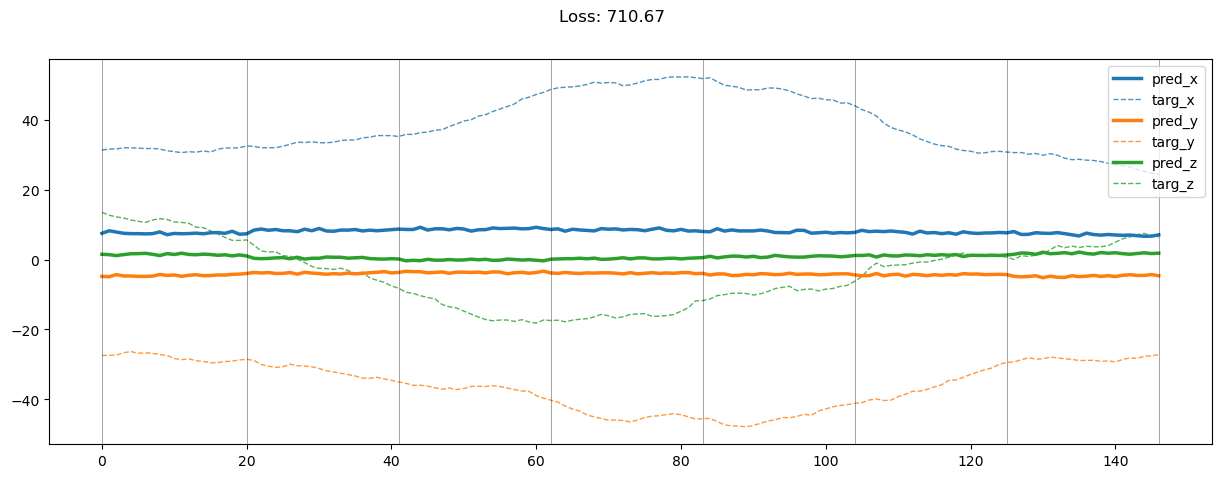

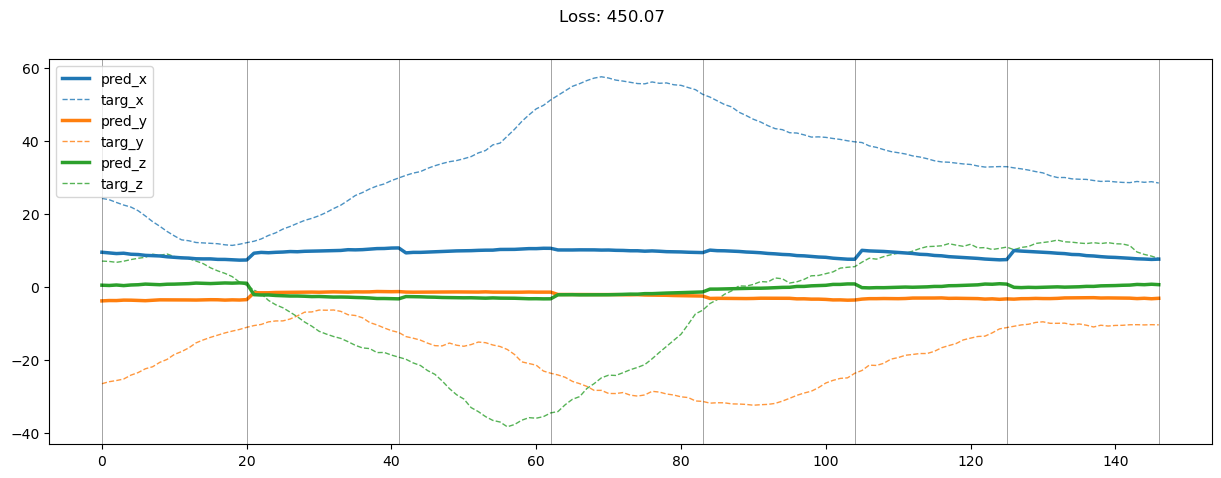

00599: train loss:  539.388, imu loss:  0.626, mag loss:  460.992, div loss:  538.762
       valid loss:  391.813, imu loss:  0.523, mag loss:  477.625, div loss:  391.290
00619: train loss:  528.825, imu loss:  0.616, mag loss:  452.840, div loss:  528.208
       valid loss:  389.750, imu loss:  0.523, mag loss:  474.799, div loss:  389.227
00639: train loss:  575.347, imu loss:  0.620, mag loss:  446.876, div loss:  574.728
       valid loss:  383.993, imu loss:  0.523, mag loss:  464.972, div loss:  383.471
00659: train loss:  520.335, imu loss:  0.602, mag loss:  419.849, div loss:  519.733
       valid loss:  378.100, imu loss:  0.523, mag loss:  460.619, div loss:  377.578
00679: train loss:  503.975, imu loss:  0.590, mag loss:  422.174, div loss:  503.385
       valid loss:  371.641, imu loss:  0.523, mag loss:  453.045, div loss:  371.118
00699: train loss:  528.373, imu loss:  0.596, mag loss:  426.016, div loss:  527.777
       valid loss:  366.373, imu loss:  0.523, mag los

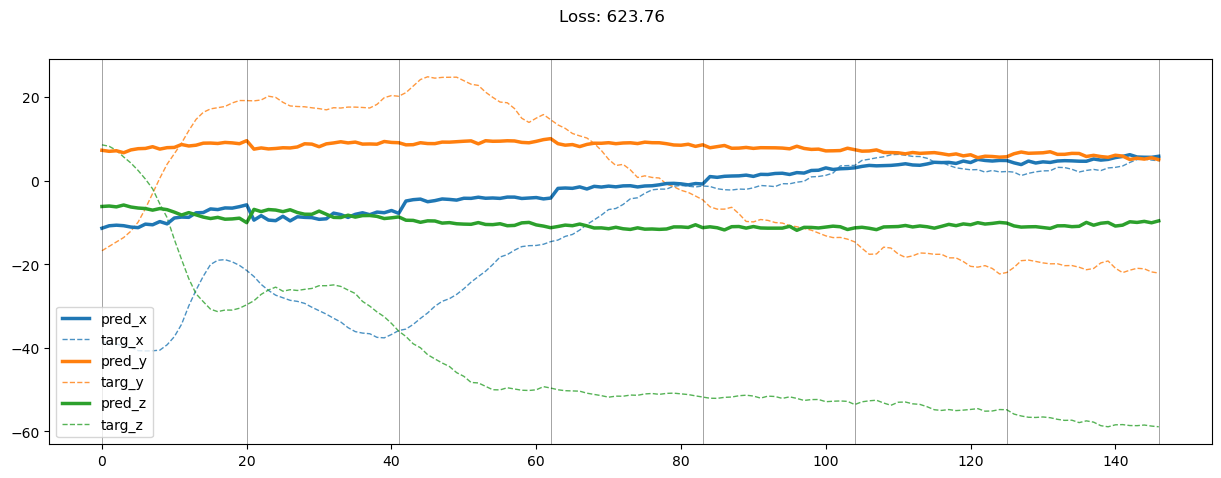

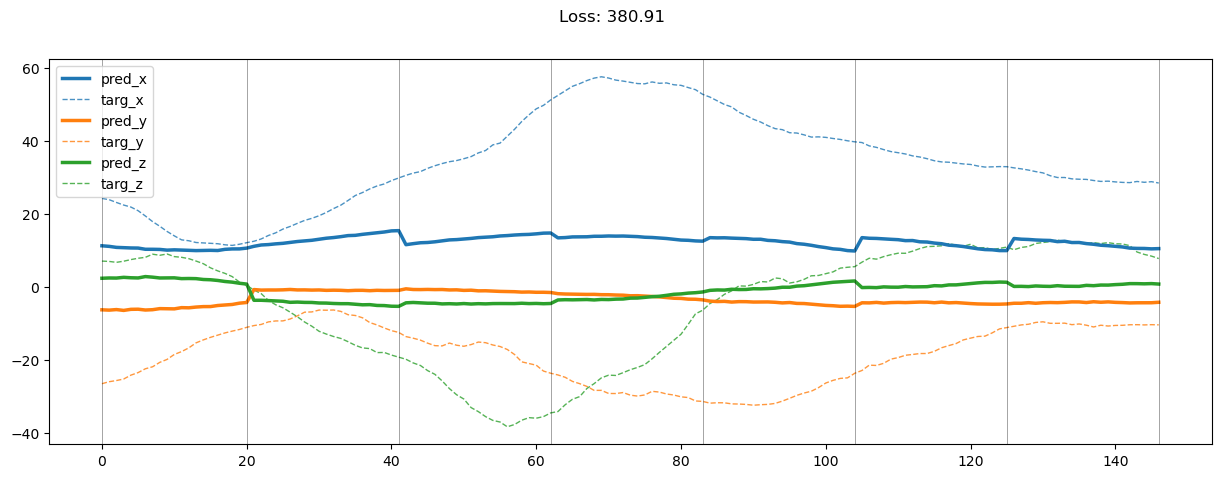

00799: train loss:  484.730, imu loss:  0.602, mag loss:  387.603, div loss:  484.128
       valid loss:  343.627, imu loss:  0.523, mag loss:  418.505, div loss:  343.104
00819: train loss:  480.152, imu loss:  0.627, mag loss:  389.873, div loss:  479.524
       valid loss:  337.540, imu loss:  0.523, mag loss:  413.046, div loss:  337.018
00839: train loss:  441.775, imu loss:  0.626, mag loss:  383.339, div loss:  441.149
       valid loss:  334.063, imu loss:  0.523, mag loss:  407.268, div loss:  333.540
00859: train loss:  421.877, imu loss:  0.630, mag loss:  369.711, div loss:  421.248
       valid loss:  325.739, imu loss:  0.523, mag loss:  403.275, div loss:  325.216
00879: train loss:  409.218, imu loss:  0.629, mag loss:  363.258, div loss:  408.589
       valid loss:  321.810, imu loss:  0.523, mag loss:  392.893, div loss:  321.287
00899: train loss:  426.306, imu loss:  0.636, mag loss:  373.706, div loss:  425.670
       valid loss:  317.745, imu loss:  0.523, mag los

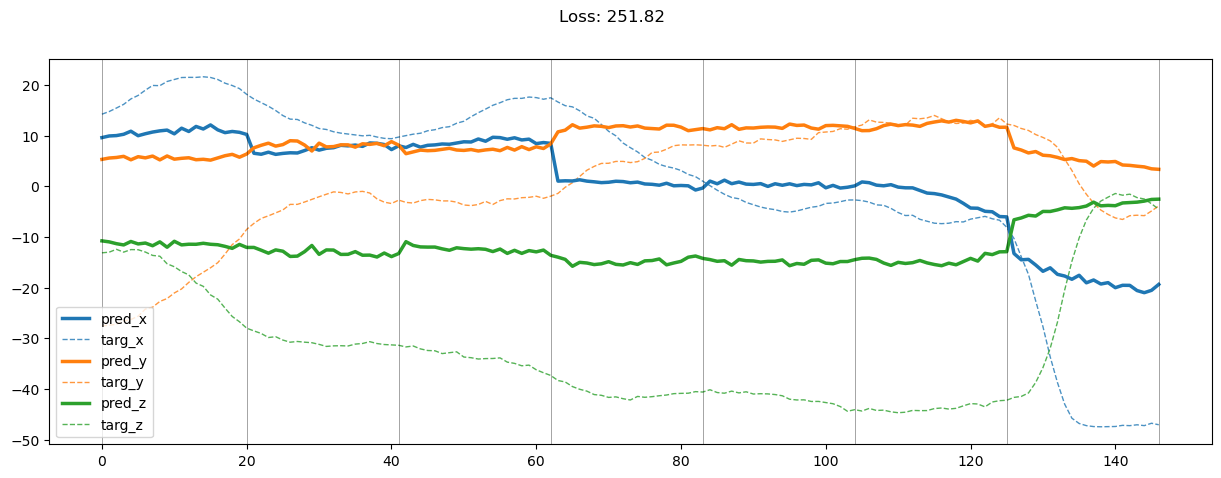

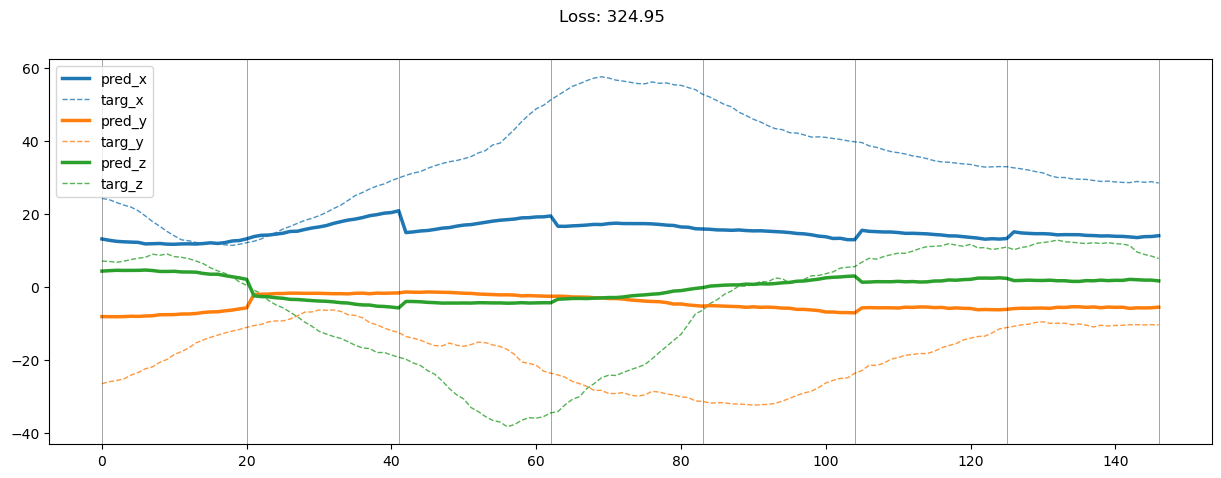

00999: train loss:  378.893, imu loss:  0.614, mag loss:  352.614, div loss:  378.279
       valid loss:  291.937, imu loss:  0.523, mag loss:  363.725, div loss:  291.414
01019: train loss:  339.129, imu loss:  0.633, mag loss:  329.710, div loss:  338.496
       valid loss:  288.959, imu loss:  0.523, mag loss:  357.440, div loss:  288.436
01039: train loss:  338.508, imu loss:  0.634, mag loss:  335.193, div loss:  337.874
       valid loss:  281.661, imu loss:  0.523, mag loss:  356.541, div loss:  281.138
01059: train loss:  316.276, imu loss:  0.604, mag loss:  313.556, div loss:  315.672
       valid loss:  280.580, imu loss:  0.523, mag loss:  350.793, div loss:  280.057
01079: train loss:  279.017, imu loss:  0.641, mag loss:  317.996, div loss:  278.376
       valid loss:  279.189, imu loss:  0.523, mag loss:  351.870, div loss:  278.666
01099: train loss:  304.042, imu loss:  0.649, mag loss:  313.560, div loss:  303.393
       valid loss:  270.400, imu loss:  0.523, mag los

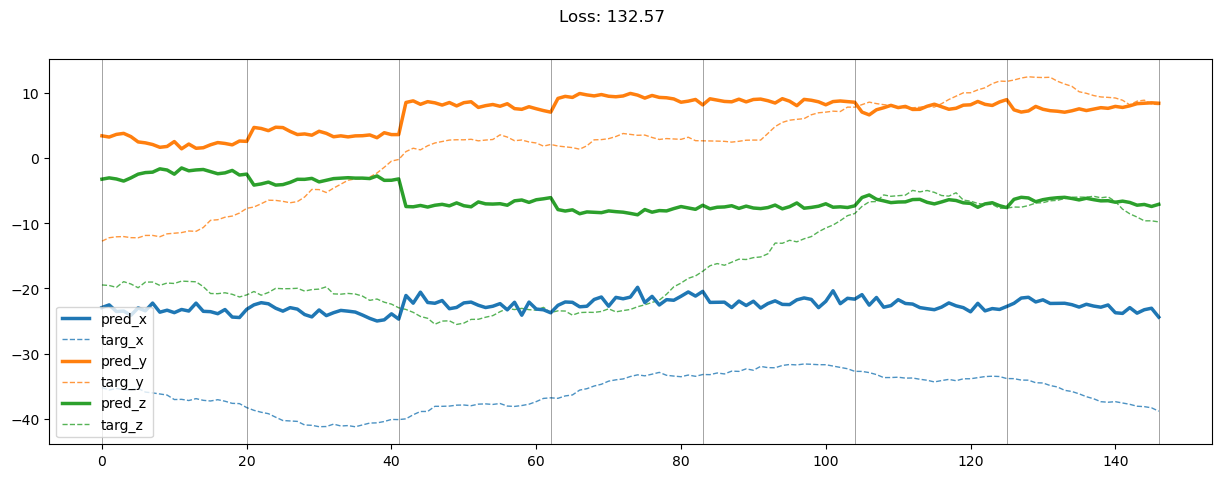

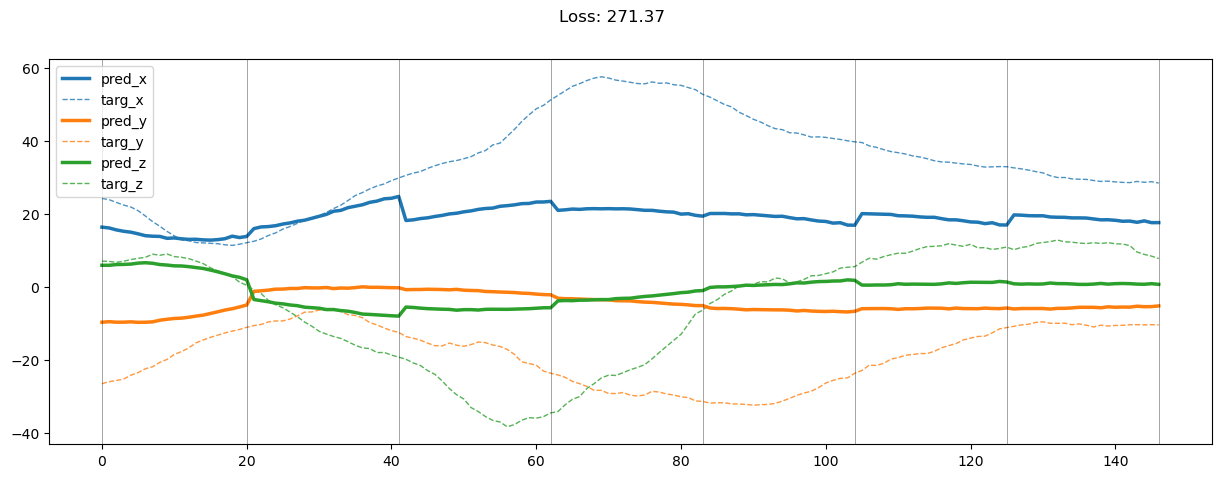

01199: train loss:  274.079, imu loss:  0.604, mag loss:  283.791, div loss:  273.475
       valid loss:  248.860, imu loss:  0.523, mag loss:  323.884, div loss:  248.337
01219: train loss:  276.743, imu loss:  0.639, mag loss:  290.892, div loss:  276.104
       valid loss:  247.550, imu loss:  0.523, mag loss:  319.044, div loss:  247.027
01239: train loss:  251.275, imu loss:  0.644, mag loss:  274.891, div loss:  250.631
       valid loss:  240.915, imu loss:  0.523, mag loss:  315.322, div loss:  240.392
01259: train loss:  259.667, imu loss:  0.618, mag loss:  274.817, div loss:  259.049
       valid loss:  235.611, imu loss:  0.523, mag loss:  310.309, div loss:  235.088
01279: train loss:  256.564, imu loss:  0.645, mag loss:  276.538, div loss:  255.919
       valid loss:  237.142, imu loss:  0.523, mag loss:  307.919, div loss:  236.619
01299: train loss:  230.216, imu loss:  0.623, mag loss:  264.036, div loss:  229.593
       valid loss:  230.790, imu loss:  0.523, mag los

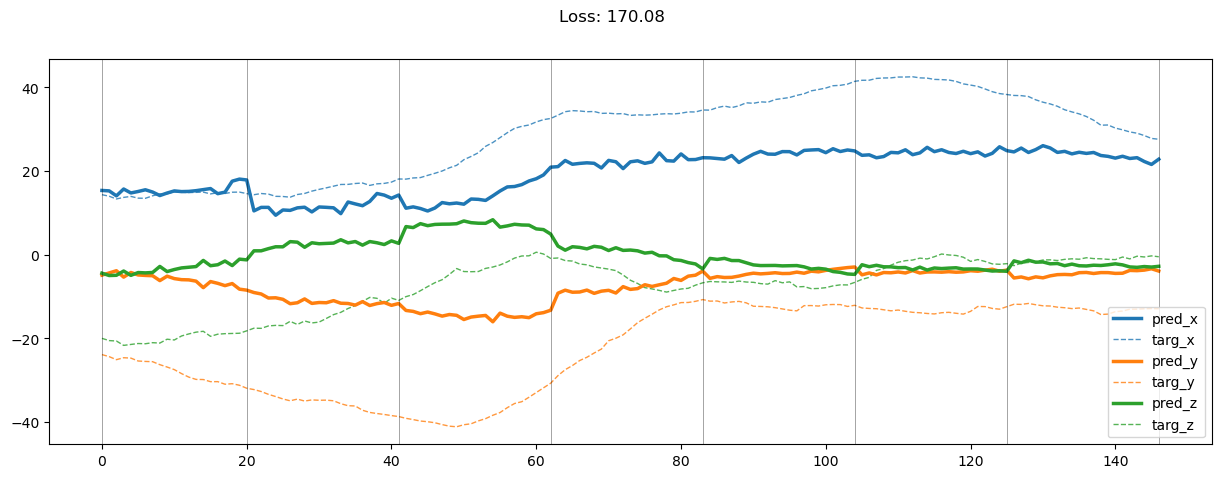

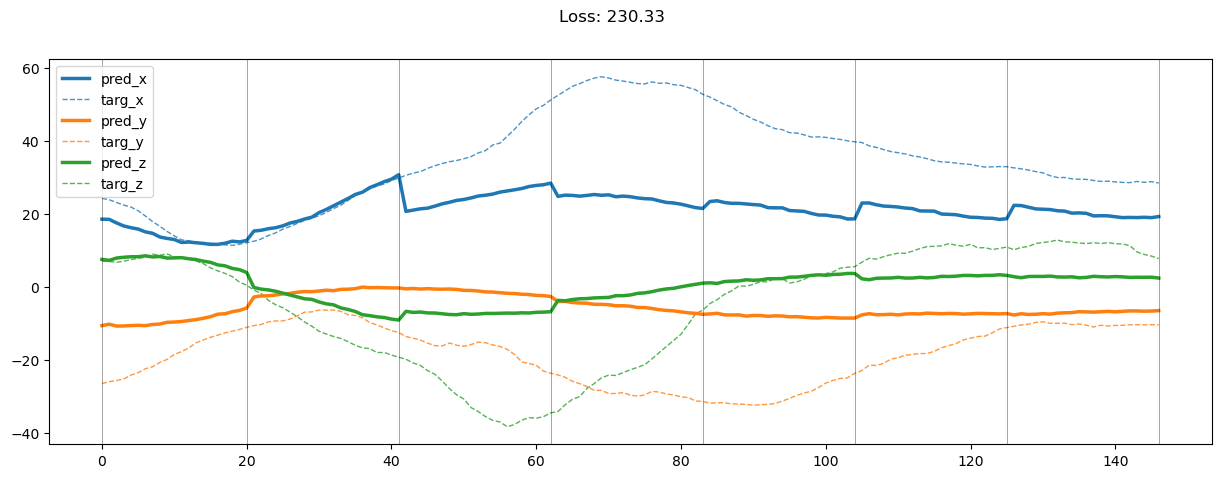

01399: train loss:  231.842, imu loss:  0.645, mag loss:  258.638, div loss:  231.197
       valid loss:  206.508, imu loss:  0.523, mag loss:  284.060, div loss:  205.985
01419: train loss:  205.534, imu loss:  0.639, mag loss:  249.673, div loss:  204.896
       valid loss:  206.649, imu loss:  0.523, mag loss:  286.144, div loss:  206.126
01439: train loss:  200.482, imu loss:  0.605, mag loss:  246.705, div loss:  199.877
       valid loss:  199.956, imu loss:  0.523, mag loss:  281.143, div loss:  199.434
01459: train loss:  210.234, imu loss:  0.616, mag loss:  239.775, div loss:  209.619
       valid loss:  205.518, imu loss:  0.523, mag loss:  280.035, div loss:  204.995
01479: train loss:  206.932, imu loss:  0.616, mag loss:  248.798, div loss:  206.316
       valid loss:  194.837, imu loss:  0.523, mag loss:  279.668, div loss:  194.315
01499: train loss:  240.127, imu loss:  0.638, mag loss:  260.169, div loss:  239.488
       valid loss:  221.760, imu loss:  0.523, mag los

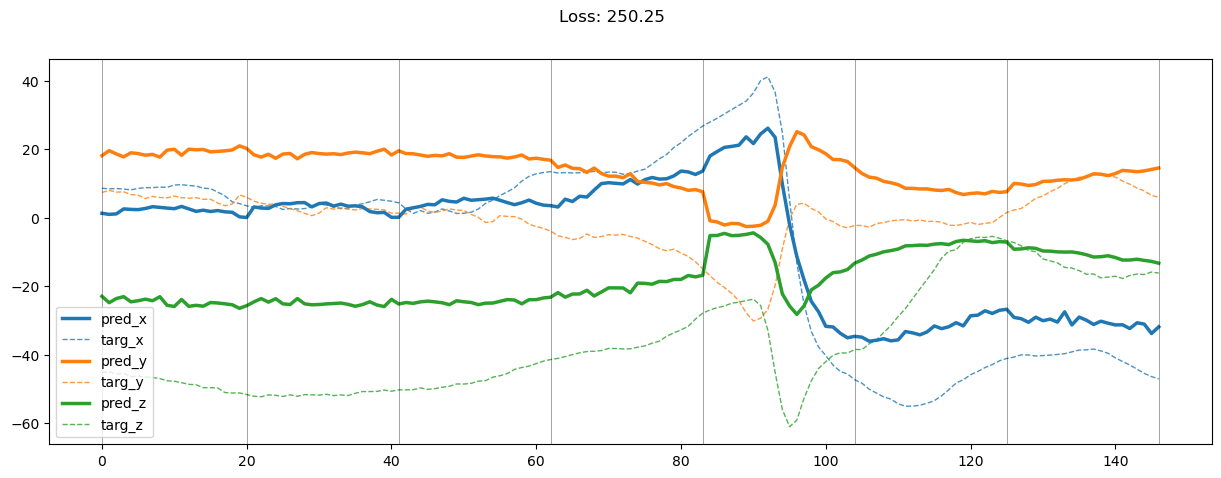

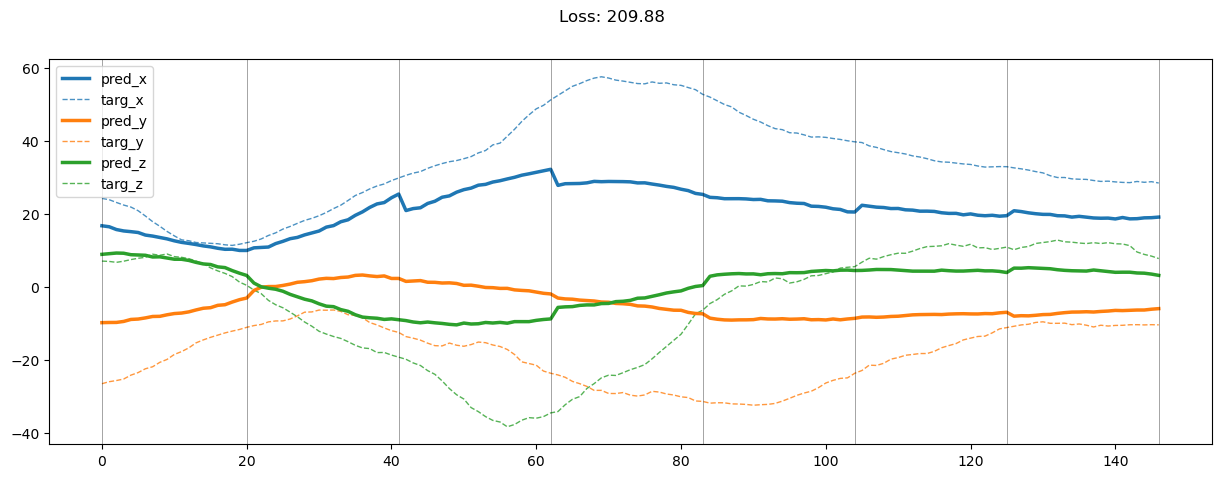

01599: train loss:  178.824, imu loss:  0.630, mag loss:  234.501, div loss:  178.194
       valid loss:  174.861, imu loss:  0.523, mag loss:  264.146, div loss:  174.338
01619: train loss:  230.215, imu loss:  0.635, mag loss:  260.414, div loss:  229.580
       valid loss:  246.333, imu loss:  0.523, mag loss:  312.933, div loss:  245.810
01639: train loss:  193.842, imu loss:  0.618, mag loss:  237.053, div loss:  193.224
       valid loss:  251.660, imu loss:  0.523, mag loss:  311.687, div loss:  251.137
01659: train loss:  192.951, imu loss:  0.619, mag loss:  241.999, div loss:  192.331
       valid loss:  206.286, imu loss:  0.523, mag loss:  278.761, div loss:  205.763
01679: train loss:  160.099, imu loss:  0.598, mag loss:  210.451, div loss:  159.501
       valid loss:  200.163, imu loss:  0.523, mag loss:  272.985, div loss:  199.640
01699: train loss:  143.603, imu loss:  0.613, mag loss:  215.405, div loss:  142.990
       valid loss:  201.879, imu loss:  0.523, mag los

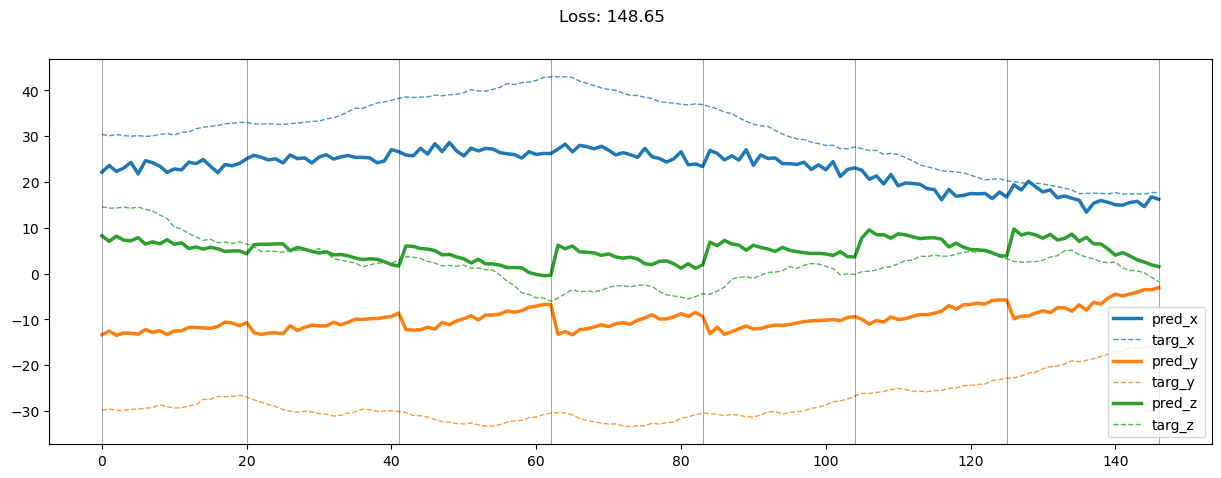

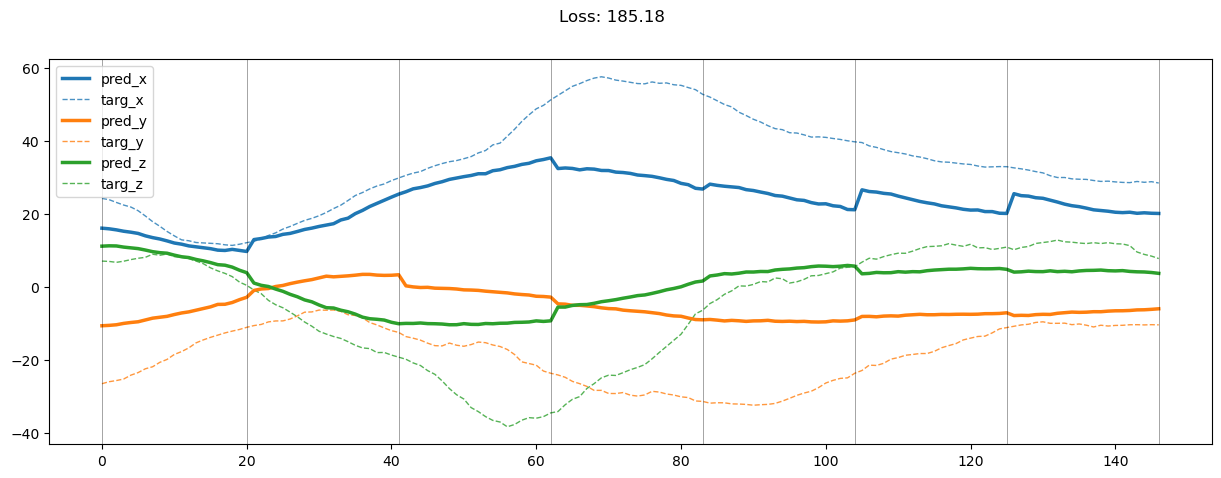

01799: train loss:  134.421, imu loss:  0.650, mag loss:  213.623, div loss:  133.772
       valid loss:  175.619, imu loss:  0.523, mag loss:  251.109, div loss:  175.097
01819: train loss:  133.635, imu loss:  0.614, mag loss:  209.670, div loss:  133.022
       valid loss:  197.133, imu loss:  0.523, mag loss:  259.107, div loss:  196.610
01839: train loss:  135.179, imu loss:  0.668, mag loss:  201.033, div loss:  134.511
       valid loss:  173.816, imu loss:  0.523, mag loss:  243.113, div loss:  173.293
01859: train loss:  138.833, imu loss:  0.638, mag loss:  204.120, div loss:  138.195
       valid loss:  176.236, imu loss:  0.523, mag loss:  241.386, div loss:  175.714
01879: train loss:  129.445, imu loss:  0.641, mag loss:  186.746, div loss:  128.804
       valid loss:  191.539, imu loss:  0.523, mag loss:  243.846, div loss:  191.016
01899: train loss:  118.400, imu loss:  0.627, mag loss:  192.581, div loss:  117.773
       valid loss:  165.521, imu loss:  0.523, mag los

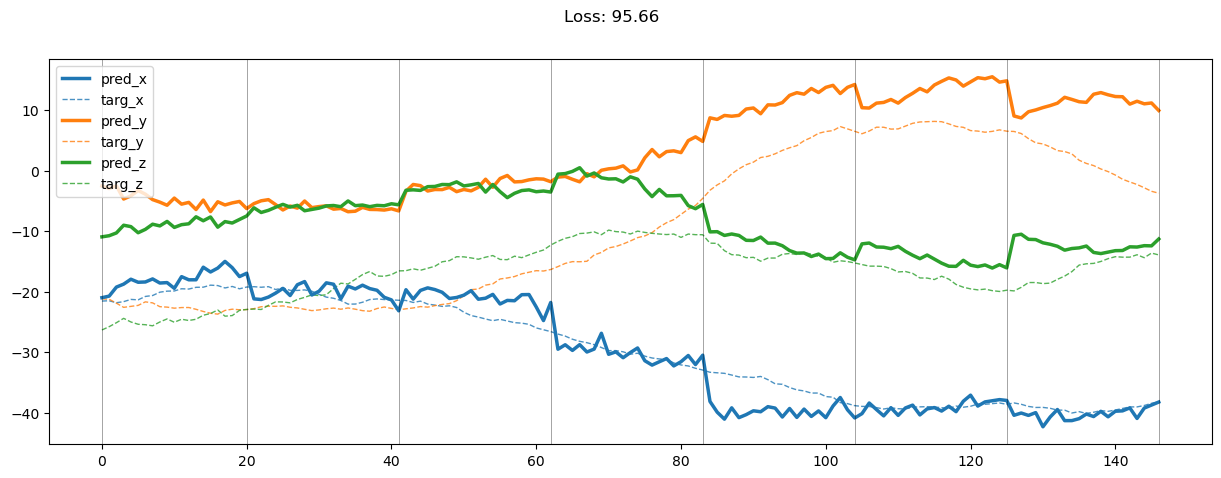

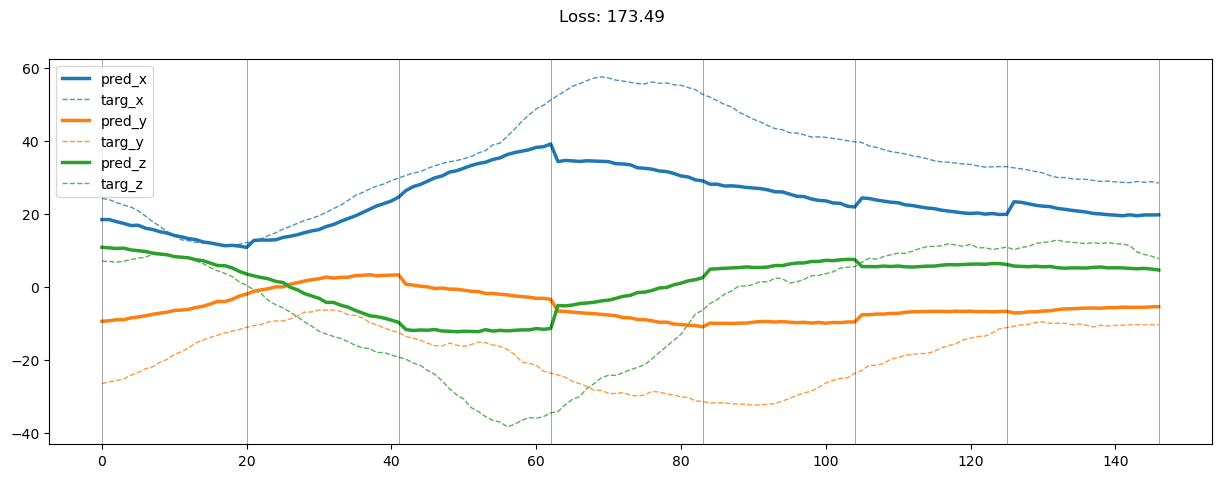

01999: train loss:  109.090, imu loss:  0.616, mag loss:  181.397, div loss:  108.474
       valid loss:  150.805, imu loss:  0.523, mag loss:  223.689, div loss:  150.282
02019: train loss:  94.684, imu loss:  0.613, mag loss:  169.578, div loss:  94.071
       valid loss:  154.787, imu loss:  0.523, mag loss:  223.754, div loss:  154.264
02039: train loss:  115.099, imu loss:  0.633, mag loss:  175.527, div loss:  114.466
       valid loss:  134.457, imu loss:  0.523, mag loss:  209.580, div loss:  133.935
02059: train loss:  104.654, imu loss:  0.647, mag loss:  176.409, div loss:  104.007
       valid loss:  132.294, imu loss:  0.523, mag loss:  211.771, div loss:  131.771
02079: train loss:  98.369, imu loss:  0.619, mag loss:  173.864, div loss:  97.751
       valid loss:  137.423, imu loss:  0.523, mag loss:  204.564, div loss:  136.900
02099: train loss:  99.348, imu loss:  0.608, mag loss:  174.820, div loss:  98.740
       valid loss:  157.433, imu loss:  0.523, mag loss:  21

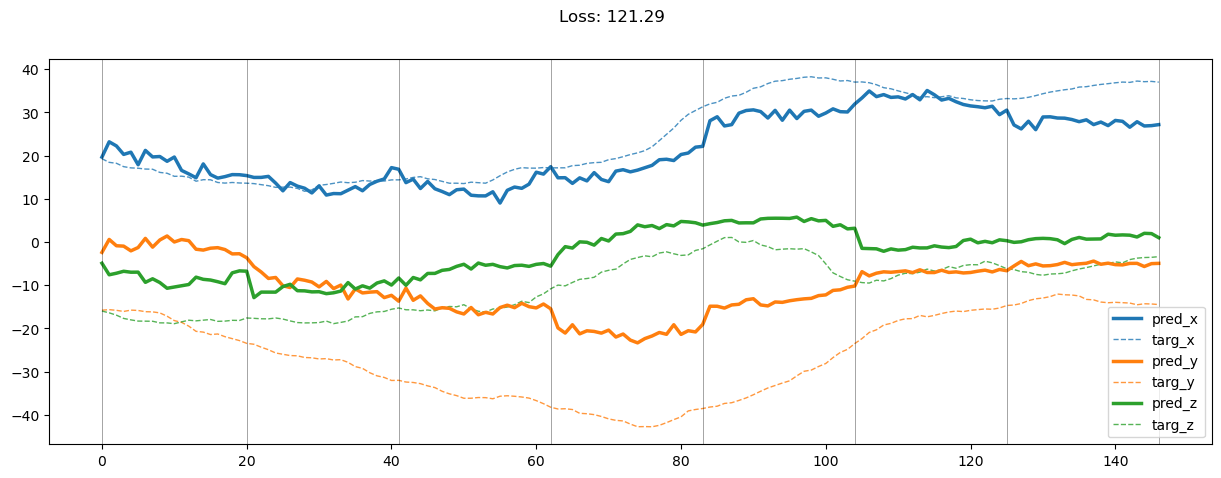

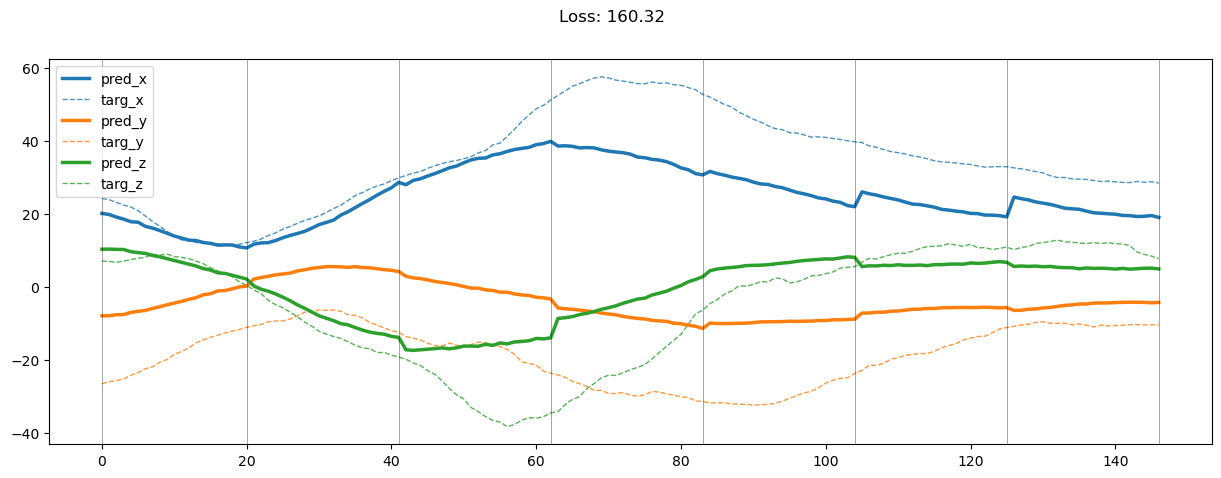

02199: train loss:  88.743, imu loss:  0.677, mag loss:  152.044, div loss:  88.066
       valid loss:  136.352, imu loss:  0.523, mag loss:  190.658, div loss:  135.829
02219: train loss:  89.720, imu loss:  0.643, mag loss:  147.071, div loss:  89.077
       valid loss:  142.769, imu loss:  0.523, mag loss:  193.380, div loss:  142.246
02239: train loss:  80.766, imu loss:  0.618, mag loss:  138.459, div loss:  80.148
       valid loss:  134.926, imu loss:  0.523, mag loss:  183.248, div loss:  134.403
02259: train loss:  79.935, imu loss:  0.603, mag loss:  146.881, div loss:  79.333
       valid loss:  139.038, imu loss:  0.523, mag loss:  188.232, div loss:  138.515
02279: train loss:  85.270, imu loss:  0.630, mag loss:  144.721, div loss:  84.640
       valid loss:  124.460, imu loss:  0.523, mag loss:  183.330, div loss:  123.938
02299: train loss:  70.605, imu loss:  0.585, mag loss:  138.050, div loss:  70.020
       valid loss:  113.431, imu loss:  0.523, mag loss:  177.804,

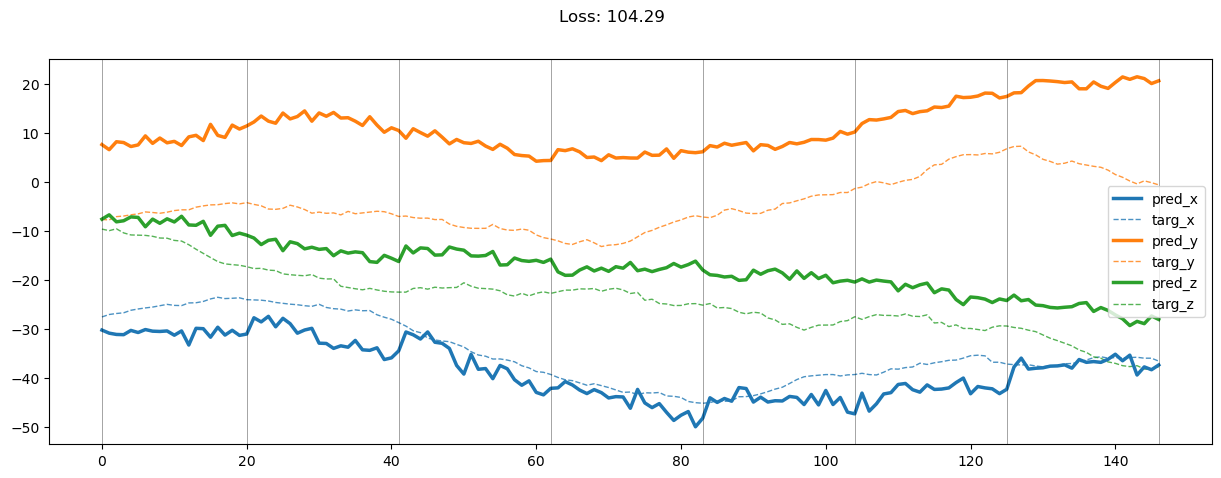

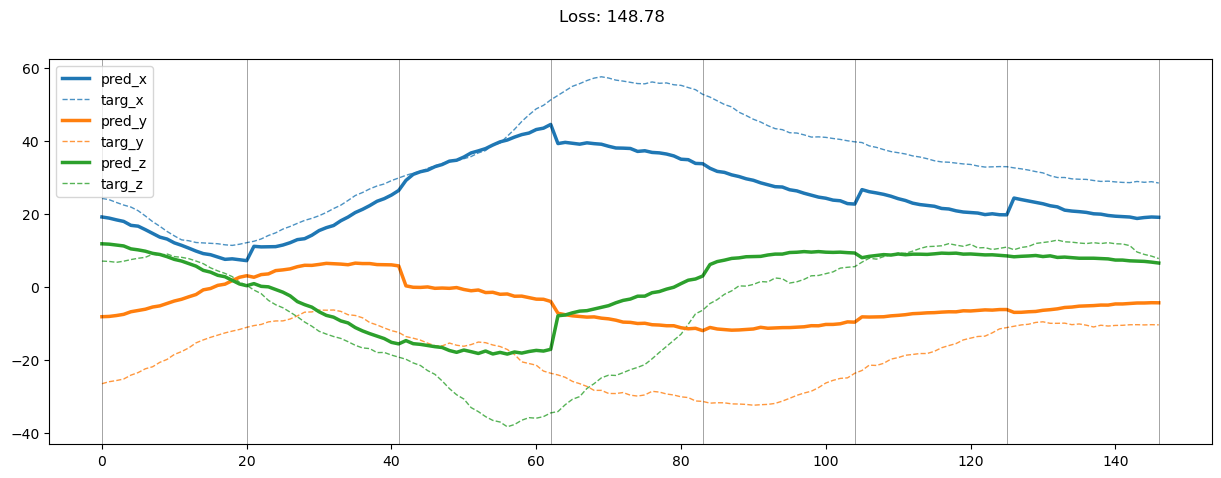

02399: train loss:  67.969, imu loss:  0.622, mag loss:  119.337, div loss:  67.347
       valid loss:  119.274, imu loss:  0.523, mag loss:  165.135, div loss:  118.752
02419: train loss:  66.683, imu loss:  0.648, mag loss:  122.302, div loss:  66.035
       valid loss:  111.572, imu loss:  0.523, mag loss:  157.274, div loss:  111.050
02439: train loss:  63.216, imu loss:  0.624, mag loss:  119.187, div loss:  62.591
       valid loss:  136.544, imu loss:  0.523, mag loss:  170.530, div loss:  136.021
02459: train loss:  67.339, imu loss:  0.623, mag loss:  115.256, div loss:  66.716
       valid loss:  137.000, imu loss:  0.523, mag loss:  166.712, div loss:  136.477
02479: train loss:  61.597, imu loss:  0.620, mag loss:  117.928, div loss:  60.977
       valid loss:  124.922, imu loss:  0.523, mag loss:  162.412, div loss:  124.399
02499: train loss:  60.788, imu loss:  0.642, mag loss:  114.304, div loss:  60.146
       valid loss:  121.074, imu loss:  0.523, mag loss:  155.453,

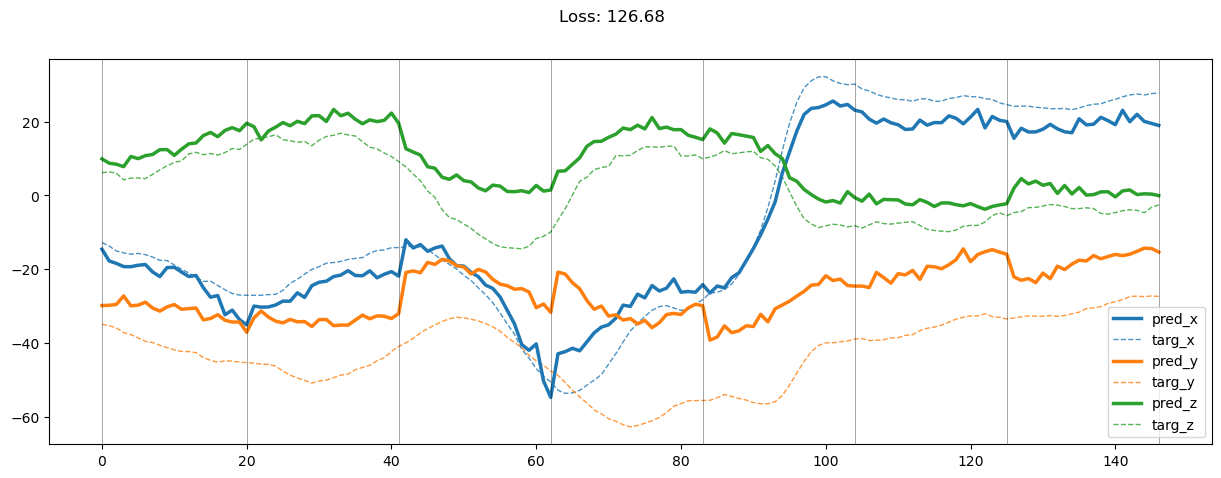

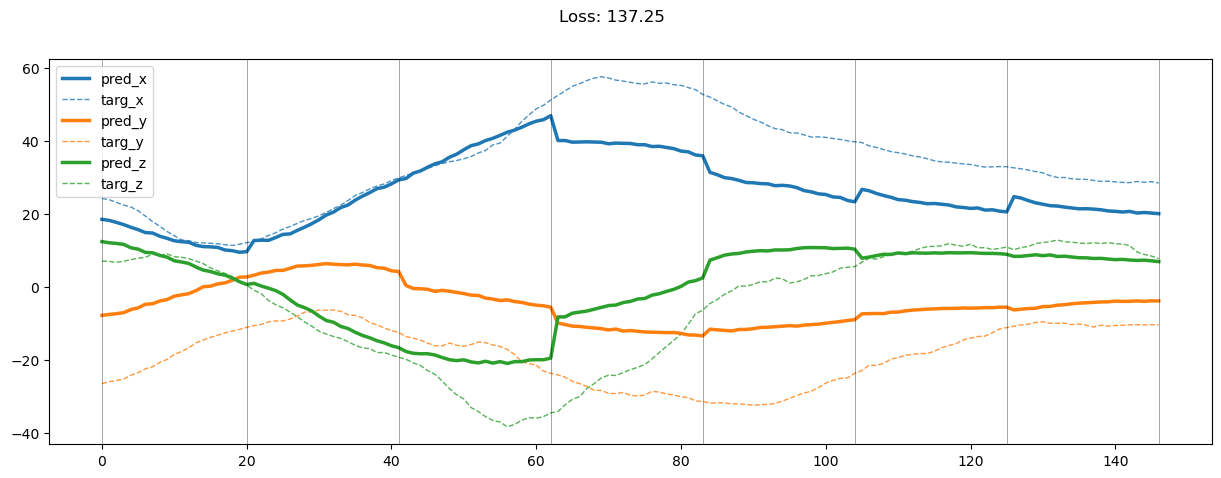

02599: train loss:  54.836, imu loss:  0.636, mag loss:  105.945, div loss:  54.200
       valid loss:  116.339, imu loss:  0.523, mag loss:  148.184, div loss:  115.817
02619: train loss:  52.028, imu loss:  0.620, mag loss:  101.769, div loss:  51.407
       valid loss:  132.669, imu loss:  0.523, mag loss:  158.029, div loss:  132.147
02639: train loss:  47.774, imu loss:  0.635, mag loss:  99.675, div loss:  47.139
       valid loss:  112.480, imu loss:  0.523, mag loss:  144.852, div loss:  111.957
02659: train loss:  47.024, imu loss:  0.610, mag loss:  105.882, div loss:  46.414
       valid loss:  119.114, imu loss:  0.523, mag loss:  153.130, div loss:  118.591
02679: train loss:  45.850, imu loss:  0.662, mag loss:  100.167, div loss:  45.188
       valid loss:  123.842, imu loss:  0.523, mag loss:  150.546, div loss:  123.319
02699: train loss:  46.022, imu loss:  0.626, mag loss:  92.161, div loss:  45.396
       valid loss:  120.385, imu loss:  0.523, mag loss:  140.646, d

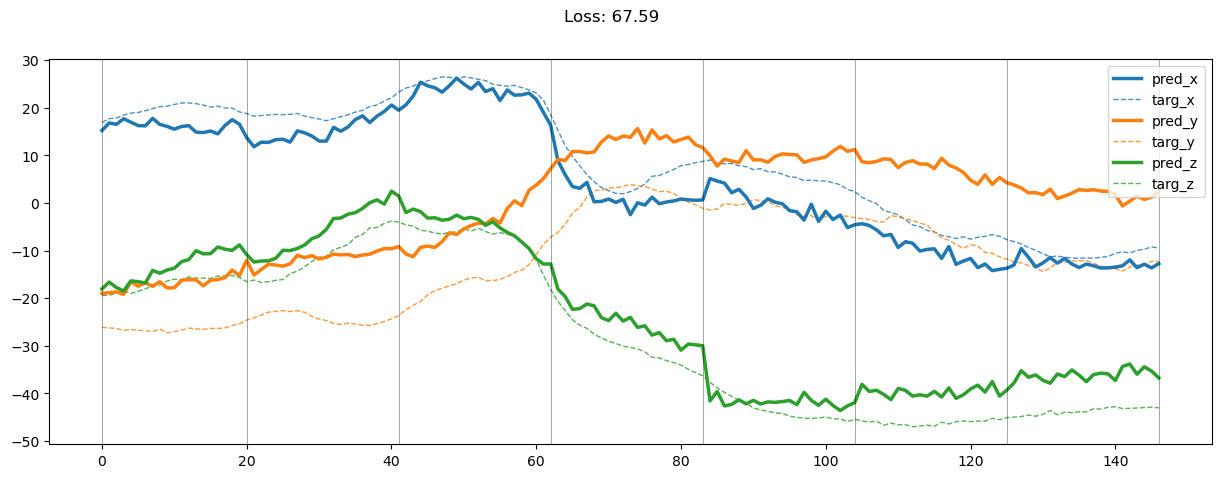

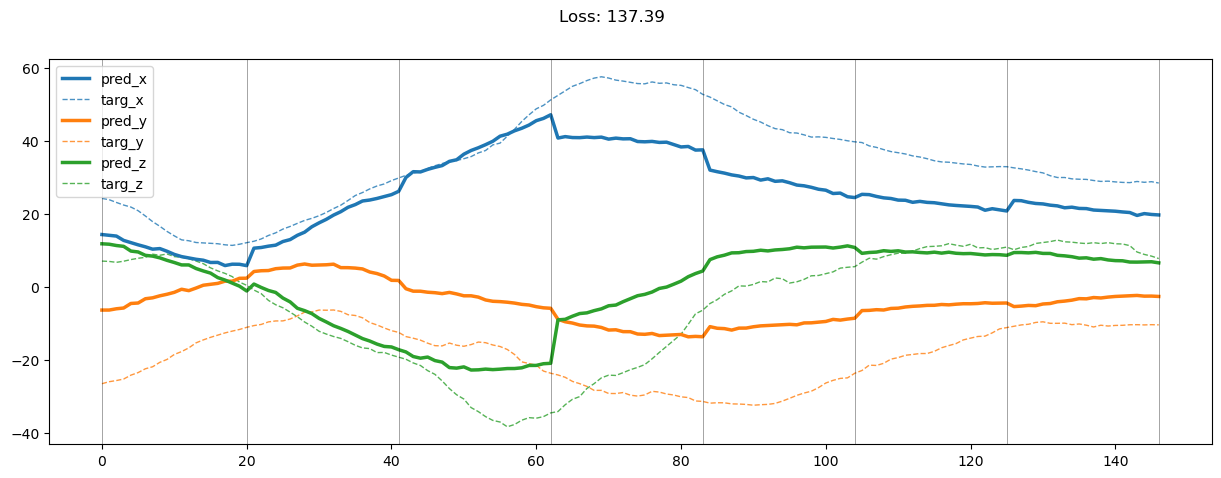

02799: train loss:  39.636, imu loss:  0.621, mag loss:  85.080, div loss:  39.015
       valid loss:  144.715, imu loss:  0.523, mag loss:  142.822, div loss:  144.193
02819: train loss:  42.441, imu loss:  0.625, mag loss:  85.929, div loss:  41.816
       valid loss:  100.434, imu loss:  0.523, mag loss:  127.223, div loss:  99.911
02839: train loss:  42.004, imu loss:  0.622, mag loss:  84.262, div loss:  41.382
       valid loss:  119.507, imu loss:  0.523, mag loss:  131.110, div loss:  118.984
02859: train loss:  37.317, imu loss:  0.627, mag loss:  83.754, div loss:  36.690
       valid loss:  117.522, imu loss:  0.523, mag loss:  133.370, div loss:  117.000
02879: train loss:  35.760, imu loss:  0.618, mag loss:  83.279, div loss:  35.142
       valid loss:  116.261, imu loss:  0.523, mag loss:  129.291, div loss:  115.738
02899: train loss:  35.008, imu loss:  0.626, mag loss:  79.671, div loss:  34.382
       valid loss:  123.400, imu loss:  0.523, mag loss:  137.000, div lo

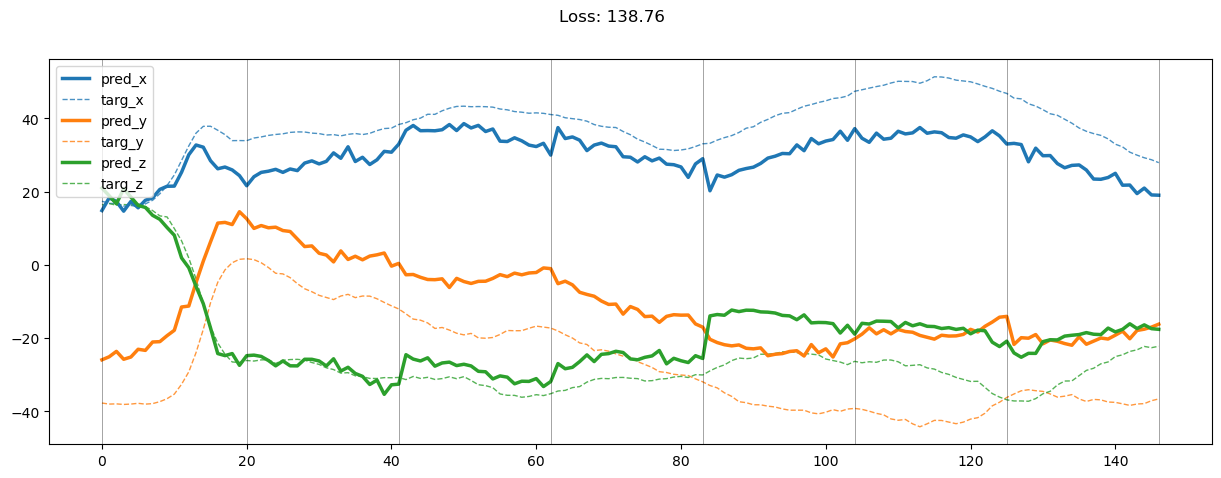

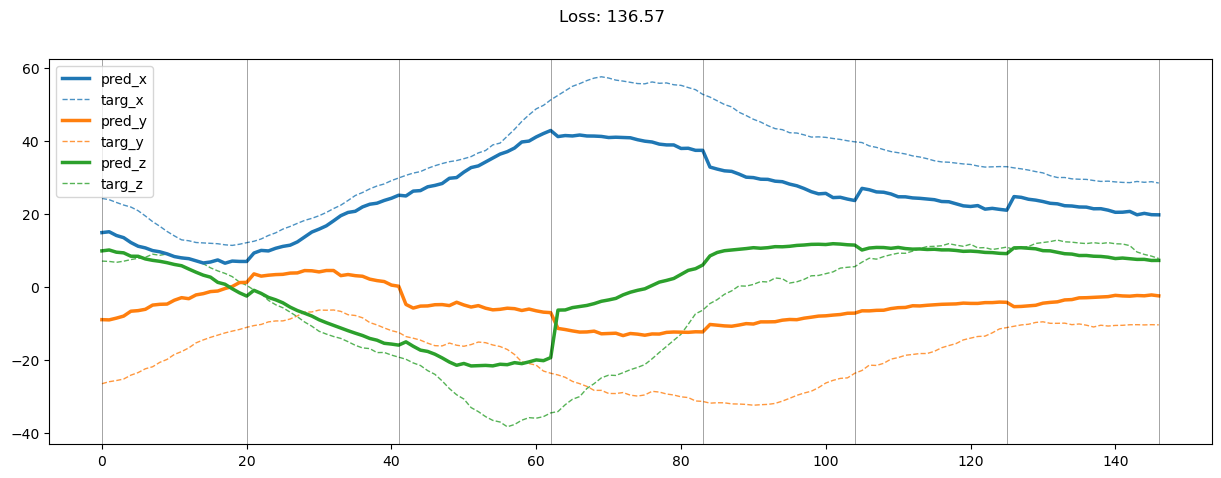

02999: train loss:  32.179, imu loss:  0.640, mag loss:  75.388, div loss:  31.540
       valid loss:  93.025, imu loss:  0.523, mag loss:  118.897, div loss:  92.503
03019: train loss:  29.093, imu loss:  0.615, mag loss:  64.866, div loss:  28.477
       valid loss:  90.988, imu loss:  0.523, mag loss:  108.503, div loss:  90.466
03039: train loss:  29.681, imu loss:  0.637, mag loss:  72.904, div loss:  29.044
       valid loss:  104.182, imu loss:  0.522, mag loss:  122.813, div loss:  103.660
03059: train loss:  30.085, imu loss:  0.641, mag loss:  68.445, div loss:  29.444
       valid loss:  99.670, imu loss:  0.522, mag loss:  116.018, div loss:  99.147
03079: train loss:  28.085, imu loss:  0.608, mag loss:  67.498, div loss:  27.478
       valid loss:  90.914, imu loss:  0.522, mag loss:  106.363, div loss:  90.392
03099: train loss:  29.007, imu loss:  0.574, mag loss:  71.021, div loss:  28.433
       valid loss:  128.117, imu loss:  0.522, mag loss:  128.146, div loss:  12

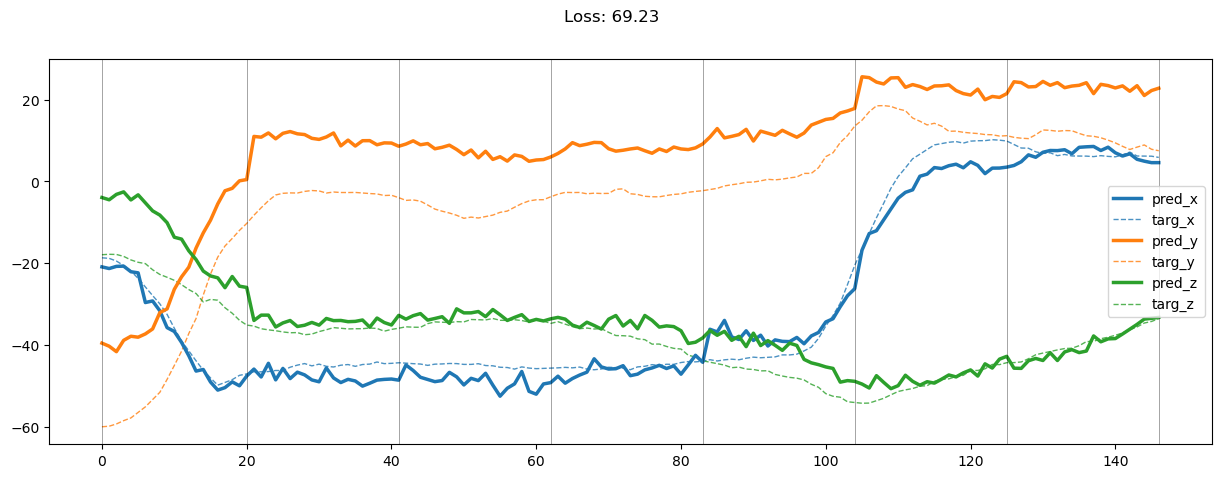

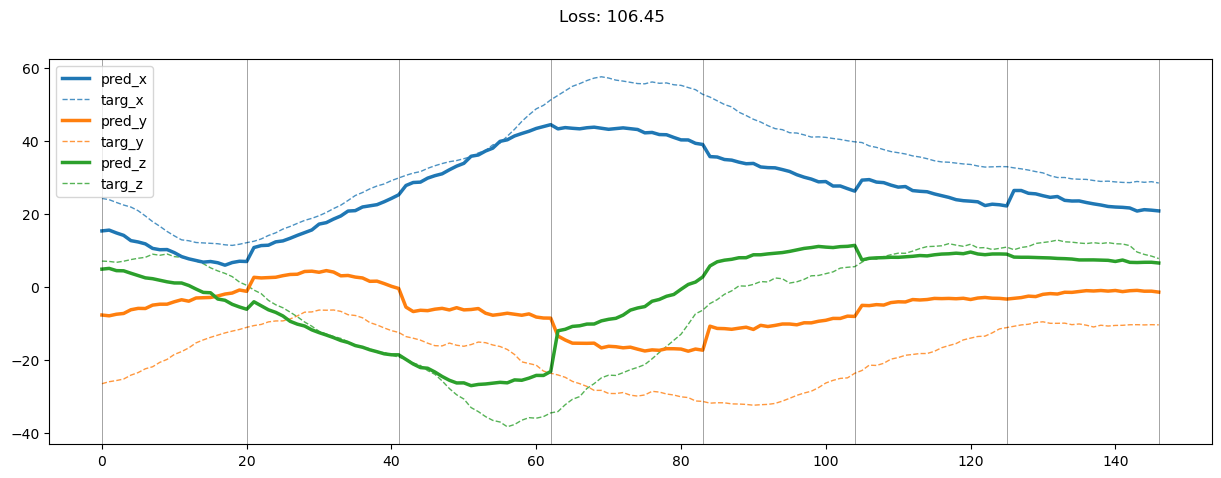

03199: train loss:  27.519, imu loss:  0.653, mag loss:  58.212, div loss:  26.867
       valid loss:  94.559, imu loss:  0.522, mag loss:  105.364, div loss:  94.036
03219: train loss:  27.663, imu loss:  0.622, mag loss:  67.988, div loss:  27.042
       valid loss:  84.861, imu loss:  0.522, mag loss:  109.920, div loss:  84.338
03239: train loss:  24.505, imu loss:  0.644, mag loss:  62.900, div loss:  23.861
       valid loss:  90.047, imu loss:  0.522, mag loss:  108.625, div loss:  89.524
03259: train loss:  24.206, imu loss:  0.591, mag loss:  60.721, div loss:  23.615
       valid loss:  96.036, imu loss:  0.522, mag loss:  108.061, div loss:  95.513
03279: train loss:  23.145, imu loss:  0.625, mag loss:  55.622, div loss:  22.521
       valid loss:  95.644, imu loss:  0.522, mag loss:  105.602, div loss:  95.122
03299: train loss:  24.645, imu loss:  0.622, mag loss:  60.104, div loss:  24.023
       valid loss:  88.496, imu loss:  0.522, mag loss:  101.670, div loss:  87.97

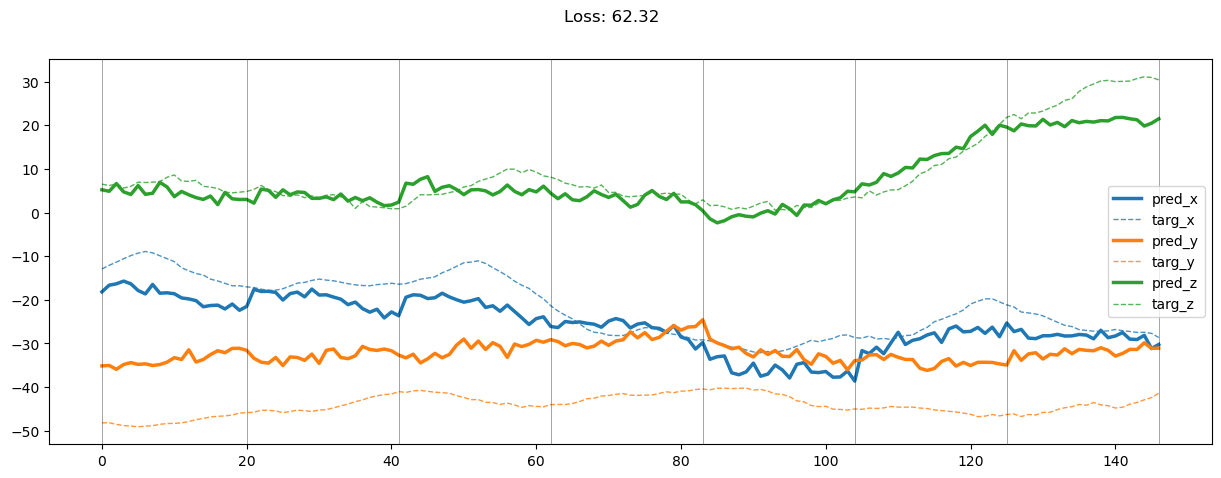

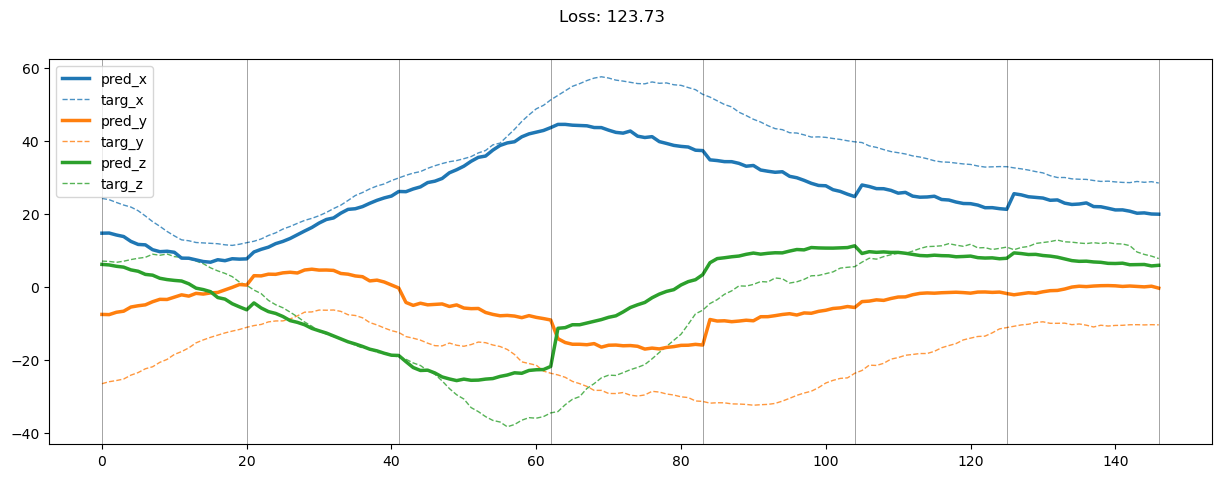

03399: train loss:  21.925, imu loss:  0.622, mag loss:  59.090, div loss:  21.304
       valid loss:  109.744, imu loss:  0.522, mag loss:  114.980, div loss:  109.221
03419: train loss:  19.265, imu loss:  0.641, mag loss:  55.798, div loss:  18.625
       valid loss:  84.548, imu loss:  0.522, mag loss:  101.134, div loss:  84.026
03439: train loss:  19.126, imu loss:  0.603, mag loss:  50.655, div loss:  18.523
       valid loss:  103.485, imu loss:  0.522, mag loss:  101.340, div loss:  102.962
03459: train loss:  21.144, imu loss:  0.636, mag loss:  54.538, div loss:  20.507
       valid loss:  99.563, imu loss:  0.522, mag loss:  103.533, div loss:  99.041
03479: train loss:  19.216, imu loss:  0.621, mag loss:  52.585, div loss:  18.595
       valid loss:  100.172, imu loss:  0.522, mag loss:  103.548, div loss:  99.650
03499: train loss:  17.901, imu loss:  0.642, mag loss:  51.762, div loss:  17.258
       valid loss:  98.275, imu loss:  0.522, mag loss:  98.560, div loss:  9

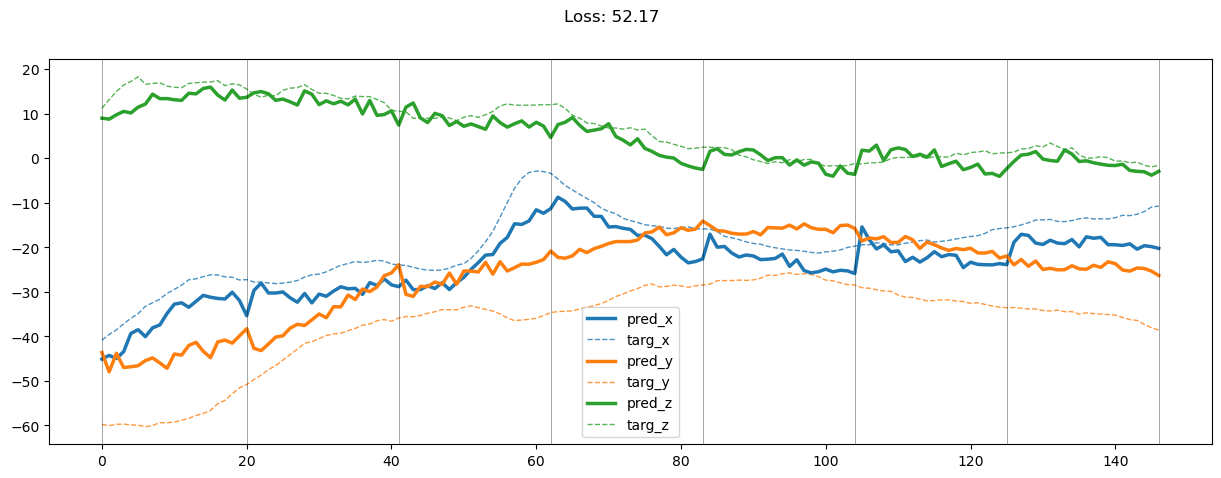

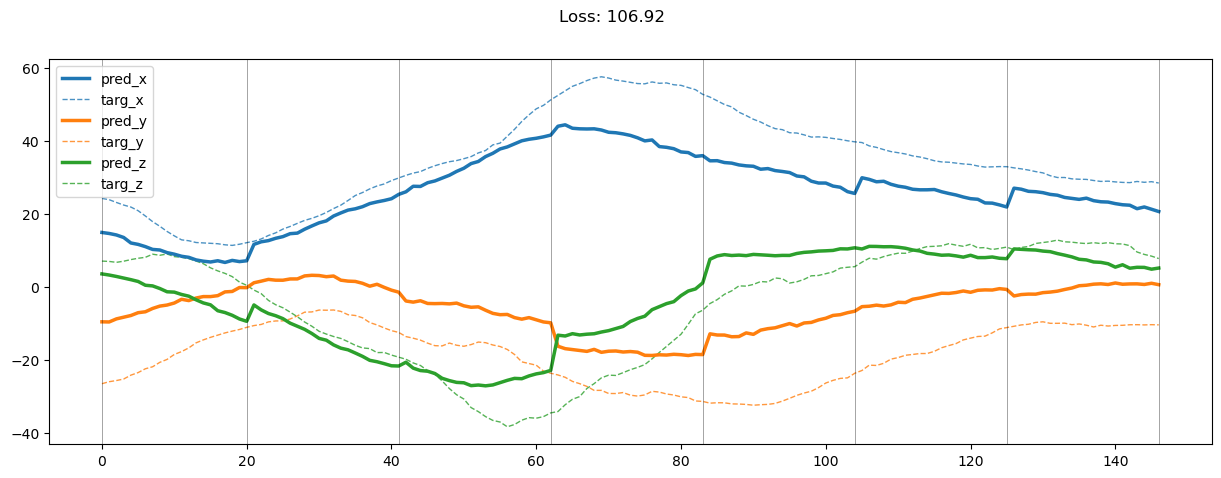

03599: train loss:  17.315, imu loss:  0.649, mag loss:  50.560, div loss:  16.665
       valid loss:  99.028, imu loss:  0.522, mag loss:  104.366, div loss:  98.506
03619: train loss:  16.015, imu loss:  0.611, mag loss:  49.975, div loss:  15.404
       valid loss:  104.123, imu loss:  0.522, mag loss:  103.229, div loss:  103.601
03639: train loss:  17.294, imu loss:  0.614, mag loss:  52.559, div loss:  16.680
       valid loss:  116.794, imu loss:  0.522, mag loss:  111.818, div loss:  116.272
03659: train loss:  15.805, imu loss:  0.620, mag loss:  49.039, div loss:  15.185
       valid loss:  112.381, imu loss:  0.522, mag loss:  106.298, div loss:  111.859
03679: train loss:  17.261, imu loss:  0.628, mag loss:  46.860, div loss:  16.632
       valid loss:  97.927, imu loss:  0.522, mag loss:  95.173, div loss:  97.405
03699: train loss:  15.648, imu loss:  0.592, mag loss:  46.515, div loss:  15.055
       valid loss:  100.927, imu loss:  0.522, mag loss:  96.188, div loss:  

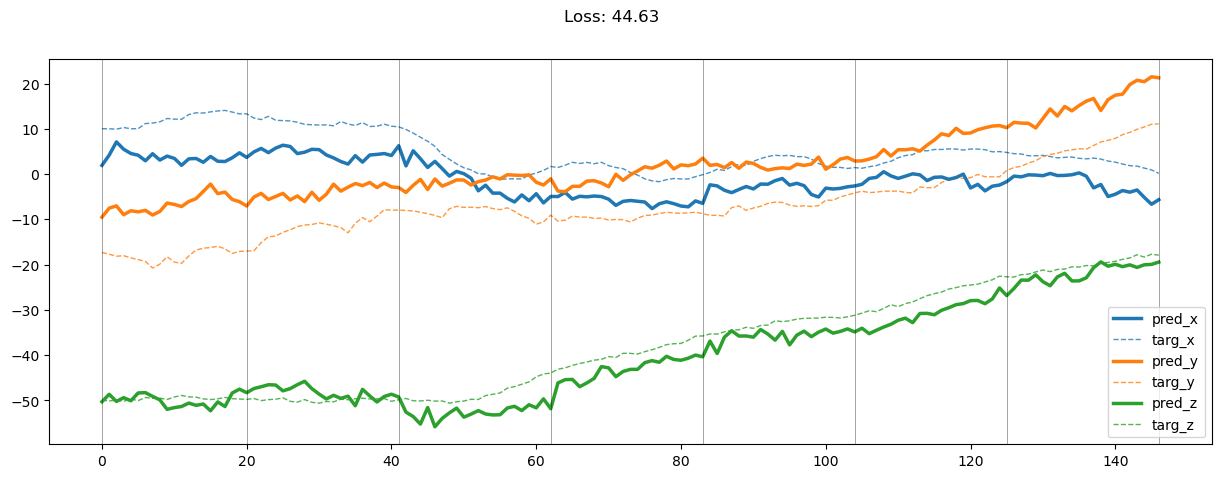

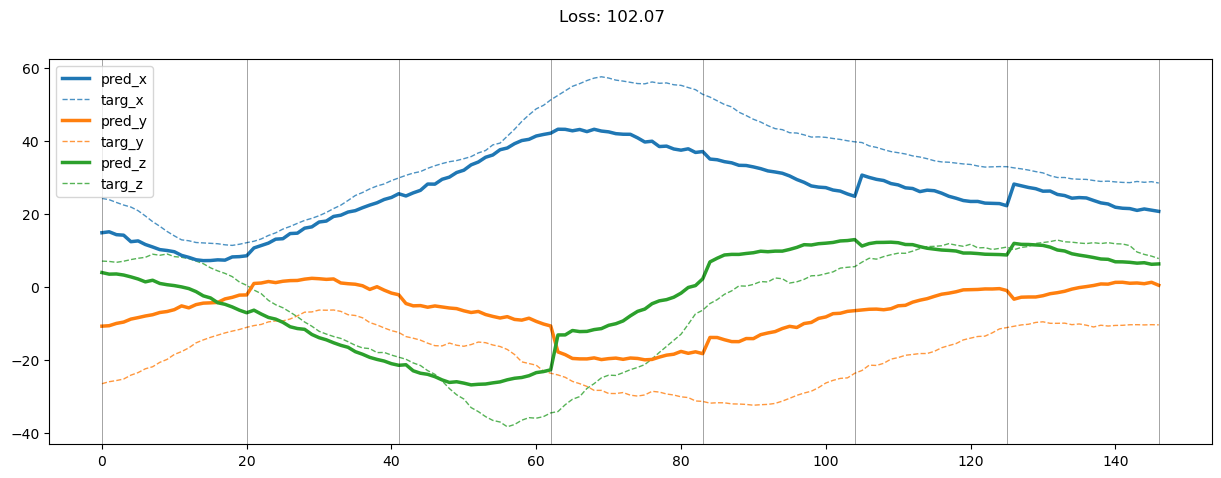

03799: train loss:  13.796, imu loss:  0.606, mag loss:  44.108, div loss:  13.190
       valid loss:  100.525, imu loss:  0.522, mag loss:  95.790, div loss:  100.003
03819: train loss:  14.915, imu loss:  0.619, mag loss:  46.209, div loss:  14.296
       valid loss:  99.492, imu loss:  0.522, mag loss:  95.003, div loss:  98.970
03839: train loss:  13.799, imu loss:  0.601, mag loss:  46.426, div loss:  13.198
       valid loss:  85.660, imu loss:  0.522, mag loss:  91.407, div loss:  85.138
03859: train loss:  12.973, imu loss:  0.615, mag loss:  41.805, div loss:  12.358
       valid loss:  91.556, imu loss:  0.522, mag loss:  87.861, div loss:  91.034
03879: train loss:  12.869, imu loss:  0.613, mag loss:  44.449, div loss:  12.255
       valid loss:  94.245, imu loss:  0.522, mag loss:  92.112, div loss:  93.723
03899: train loss:  13.049, imu loss:  0.637, mag loss:  44.060, div loss:  12.411
       valid loss:  91.869, imu loss:  0.522, mag loss:  90.535, div loss:  91.347
03

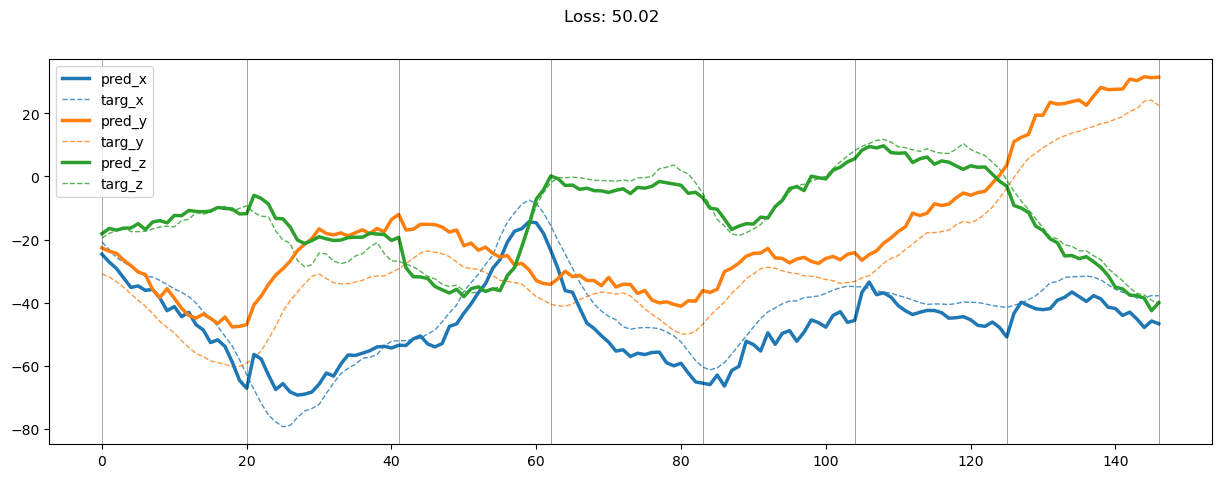

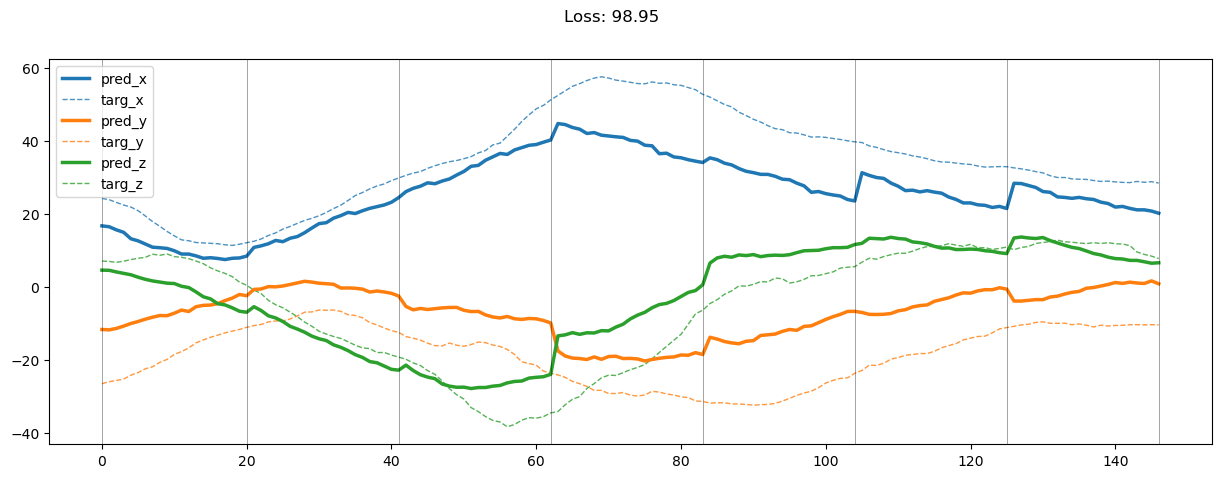

03999: train loss:  11.080, imu loss:  0.649, mag loss:  40.701, div loss:  10.430
       valid loss:  92.378, imu loss:  0.522, mag loss:  90.801, div loss:  91.856
04019: train loss:  12.348, imu loss:  0.651, mag loss:  40.865, div loss:  11.696
       valid loss:  94.704, imu loss:  0.522, mag loss:  91.461, div loss:  94.183
04039: train loss:  12.593, imu loss:  0.630, mag loss:  42.862, div loss:  11.963
       valid loss:  97.432, imu loss:  0.522, mag loss:  95.716, div loss:  96.910
04059: train loss:  12.119, imu loss:  0.607, mag loss:  40.642, div loss:  11.512
       valid loss:  105.212, imu loss:  0.522, mag loss:  96.438, div loss:  104.690
04079: train loss:  11.394, imu loss:  0.628, mag loss:  39.007, div loss:  10.766
       valid loss:  91.318, imu loss:  0.522, mag loss:  88.849, div loss:  90.797
04099: train loss:  11.310, imu loss:  0.611, mag loss:  44.448, div loss:  10.698
       valid loss:  112.449, imu loss:  0.522, mag loss:  103.472, div loss:  111.928

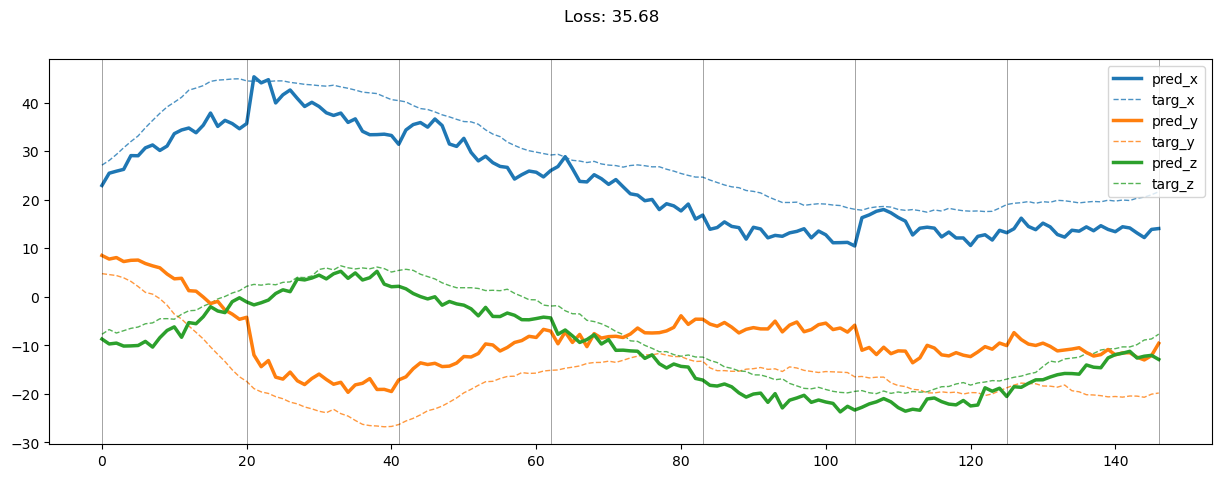

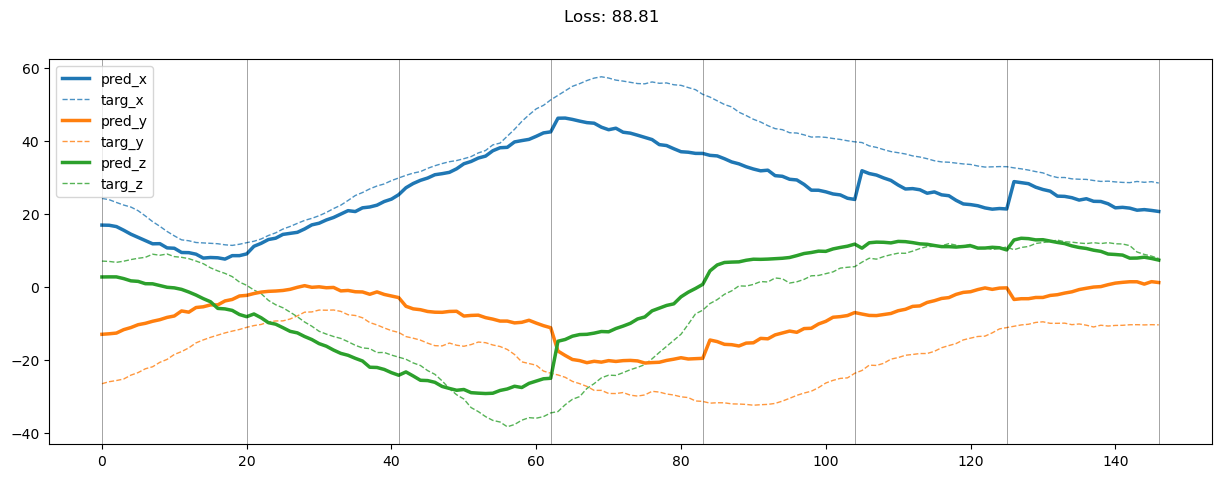

04199: train loss:  10.746, imu loss:  0.632, mag loss:  36.519, div loss:  10.114
       valid loss:  103.921, imu loss:  0.522, mag loss:  90.214, div loss:  103.399
04219: train loss:  10.213, imu loss:  0.642, mag loss:  38.654, div loss:  9.571
       valid loss:  103.205, imu loss:  0.522, mag loss:  93.623, div loss:  102.683
04239: train loss:  9.582, imu loss:  0.614, mag loss:  37.369, div loss:  8.968
       valid loss:  105.284, imu loss:  0.522, mag loss:  92.167, div loss:  104.762
04259: train loss:  10.413, imu loss:  0.643, mag loss:  35.471, div loss:  9.770
       valid loss:  104.419, imu loss:  0.522, mag loss:  90.076, div loss:  103.898
04279: train loss:  9.397, imu loss:  0.607, mag loss:  32.773, div loss:  8.790
       valid loss:  80.639, imu loss:  0.522, mag loss:  77.406, div loss:  80.118
04299: train loss:  9.652, imu loss:  0.599, mag loss:  36.899, div loss:  9.053
       valid loss:  109.813, imu loss:  0.522, mag loss:  95.532, div loss:  109.292
04

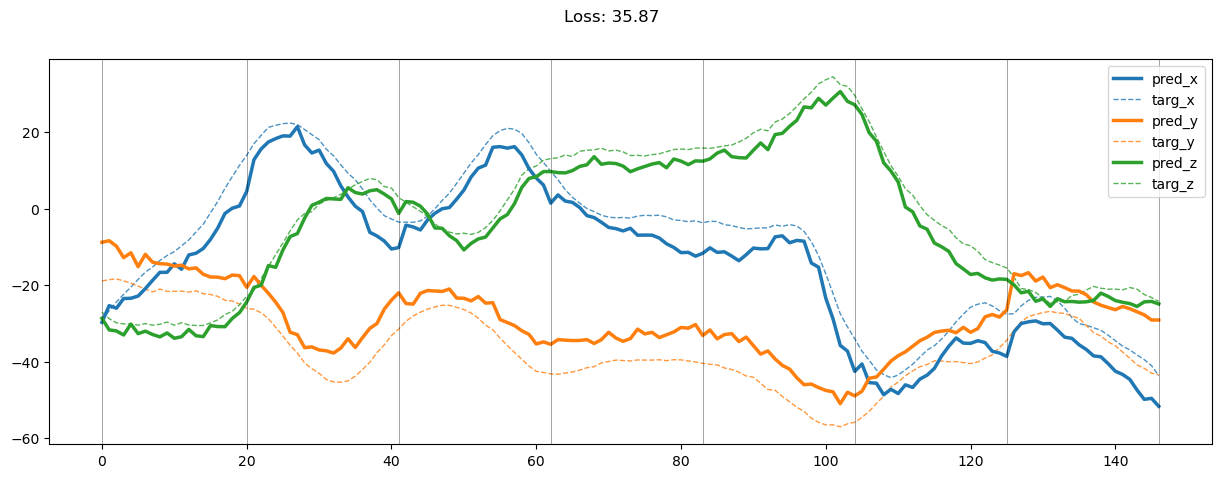

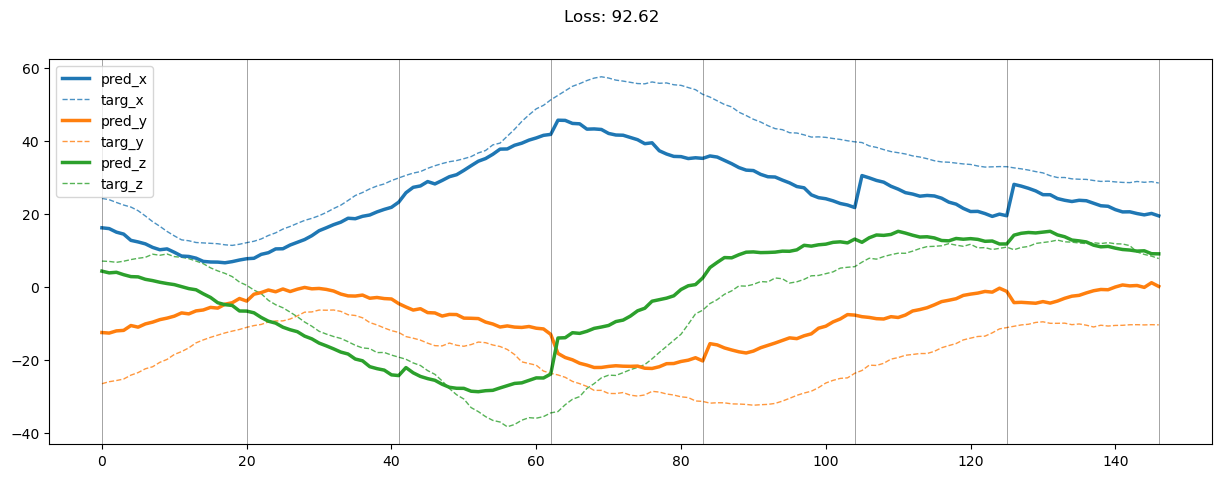

04399: train loss:  8.884, imu loss:  0.608, mag loss:  34.692, div loss:  8.276
       valid loss:  86.138, imu loss:  0.522, mag loss:  83.490, div loss:  85.617
04419: train loss:  9.325, imu loss:  0.616, mag loss:  33.254, div loss:  8.709
       valid loss:  82.124, imu loss:  0.522, mag loss:  81.007, div loss:  81.603
04439: train loss:  9.351, imu loss:  0.613, mag loss:  32.800, div loss:  8.738
       valid loss:  76.473, imu loss:  0.522, mag loss:  76.331, div loss:  75.951
04459: train loss:  9.149, imu loss:  0.632, mag loss:  33.941, div loss:  8.516
       valid loss:  90.884, imu loss:  0.522, mag loss:  81.894, div loss:  90.363
04479: train loss:  8.508, imu loss:  0.591, mag loss:  29.829, div loss:  7.918
       valid loss:  92.128, imu loss:  0.522, mag loss:  82.333, div loss:  91.607
04499: train loss:  8.291, imu loss:  0.611, mag loss:  32.351, div loss:  7.680
       valid loss:  87.357, imu loss:  0.522, mag loss:  81.882, div loss:  86.835
04519: train los

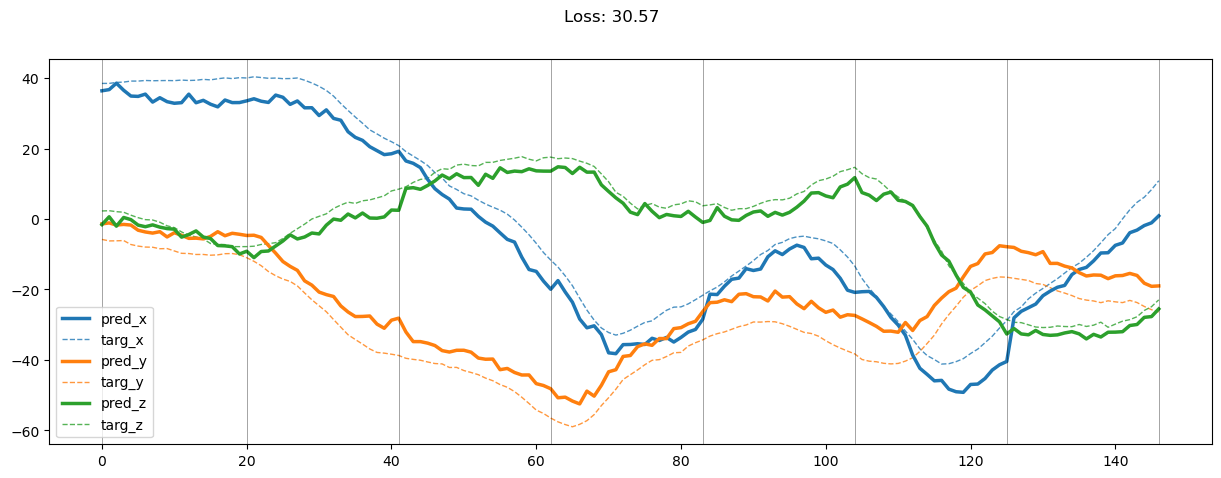

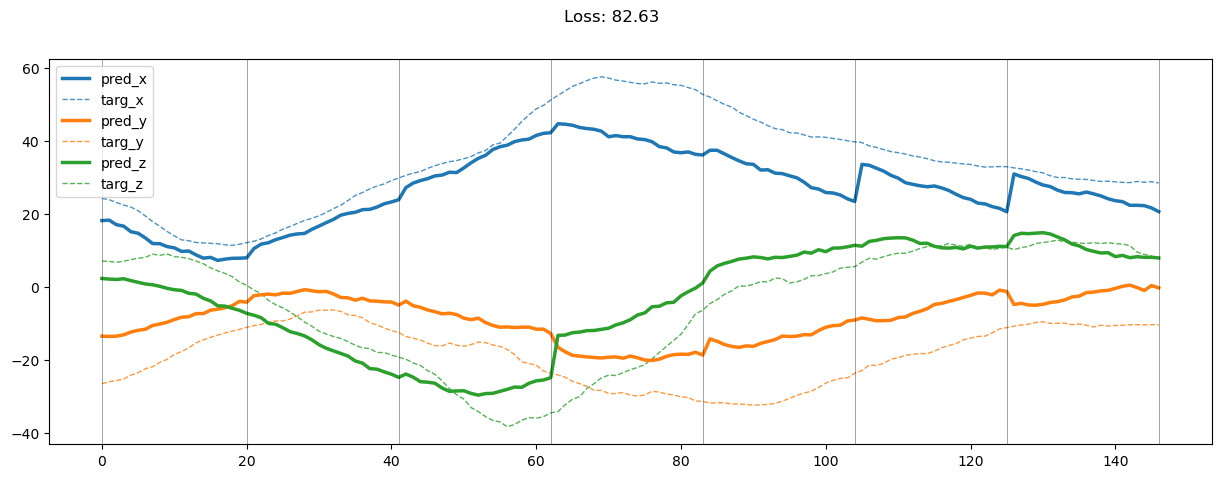

04599: train loss:  8.299, imu loss:  0.632, mag loss:  29.726, div loss:  7.667
       valid loss:  86.249, imu loss:  0.522, mag loss:  79.811, div loss:  85.727
04619: train loss:  8.072, imu loss:  0.633, mag loss:  29.931, div loss:  7.440
       valid loss:  80.678, imu loss:  0.522, mag loss:  74.503, div loss:  80.157
04639: train loss:  7.833, imu loss:  0.618, mag loss:  31.140, div loss:  7.215
       valid loss:  80.717, imu loss:  0.522, mag loss:  76.794, div loss:  80.196
04659: train loss:  8.539, imu loss:  0.632, mag loss:  32.298, div loss:  7.907
       valid loss:  88.685, imu loss:  0.522, mag loss:  80.940, div loss:  88.163
04679: train loss:  8.246, imu loss:  0.630, mag loss:  32.466, div loss:  7.616
       valid loss:  92.119, imu loss:  0.522, mag loss:  84.872, div loss:  91.598
04699: train loss:  7.932, imu loss:  0.650, mag loss:  31.332, div loss:  7.282
       valid loss:  90.213, imu loss:  0.522, mag loss:  83.317, div loss:  89.691
04719: train los

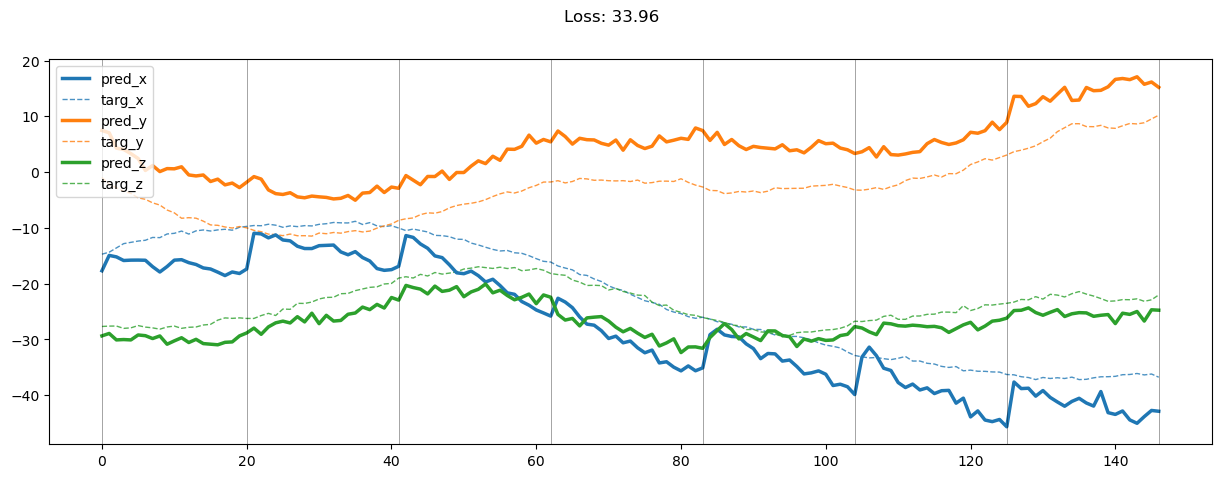

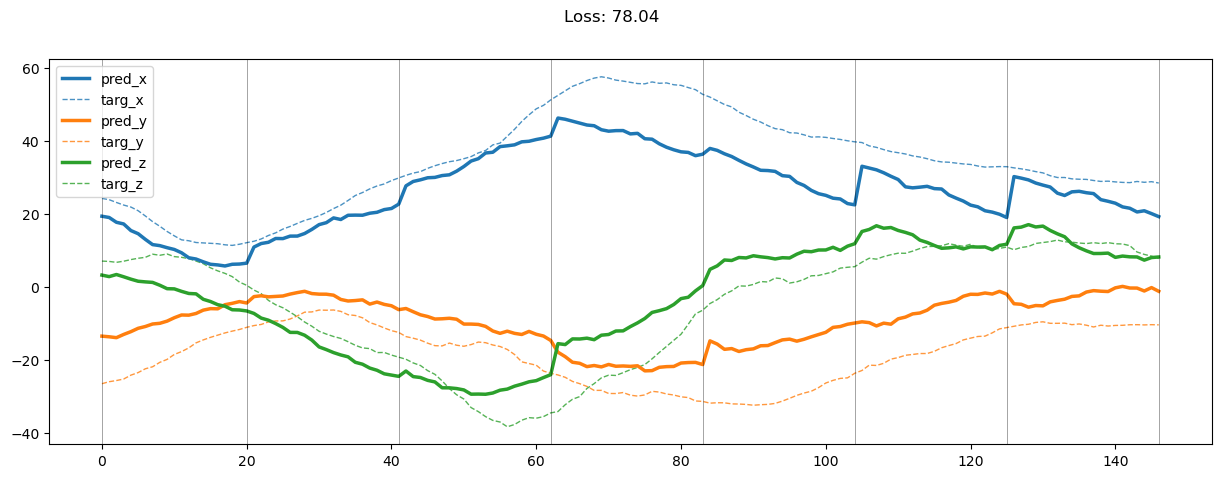

04799: train loss:  7.751, imu loss:  0.650, mag loss:  30.259, div loss:  7.101
       valid loss:  88.784, imu loss:  0.521, mag loss:  79.599, div loss:  88.263
04819: train loss:  7.305, imu loss:  0.620, mag loss:  29.983, div loss:  6.685
       valid loss:  82.361, imu loss:  0.521, mag loss:  77.478, div loss:  81.839
04839: train loss:  7.245, imu loss:  0.618, mag loss:  29.441, div loss:  6.627
       valid loss:  104.694, imu loss:  0.521, mag loss:  87.445, div loss:  104.172
04859: train loss:  7.367, imu loss:  0.626, mag loss:  30.422, div loss:  6.742
       valid loss:  82.649, imu loss:  0.521, mag loss:  79.558, div loss:  82.128
04879: train loss:  7.465, imu loss:  0.623, mag loss:  27.706, div loss:  6.842
       valid loss:  89.644, imu loss:  0.521, mag loss:  77.599, div loss:  89.122
04899: train loss:  7.645, imu loss:  0.639, mag loss:  28.437, div loss:  7.007
       valid loss:  73.221, imu loss:  0.521, mag loss:  70.889, div loss:  72.700
04919: train l

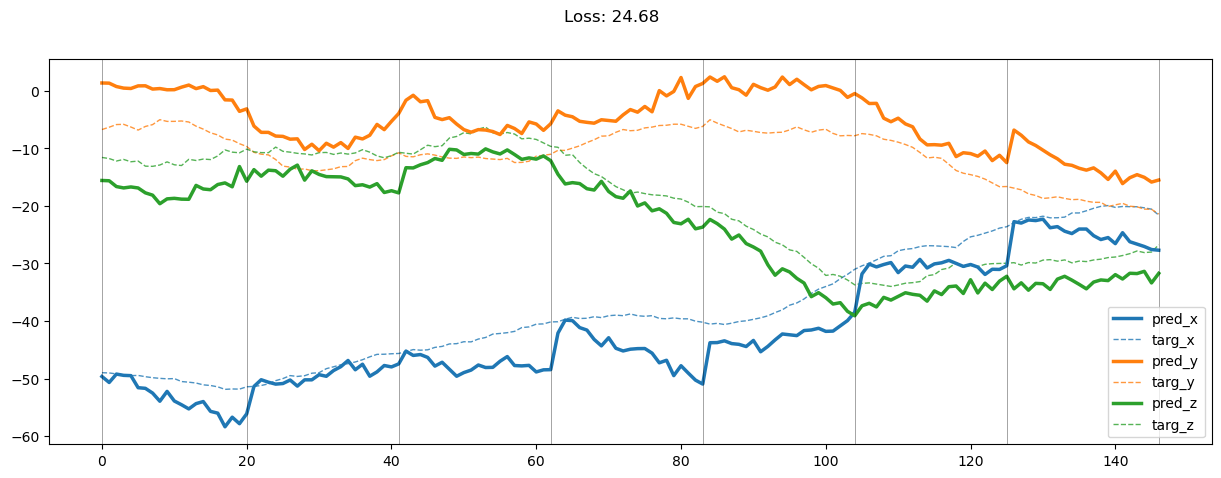

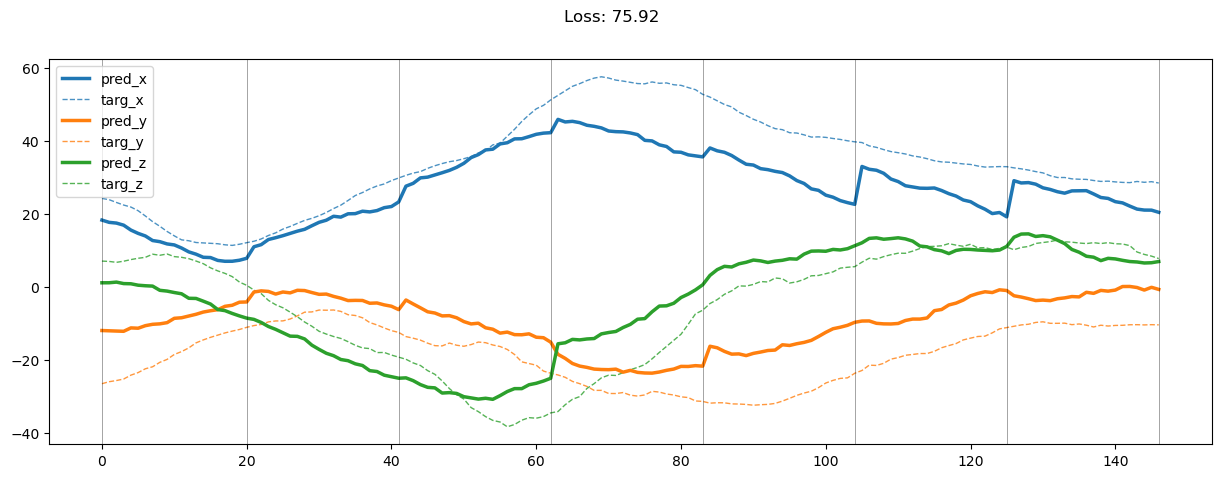

04999: train loss:  6.933, imu loss:  0.615, mag loss:  27.207, div loss:  6.318
       valid loss:  93.855, imu loss:  0.521, mag loss:  80.062, div loss:  93.333
05019: train loss:  6.952, imu loss:  0.629, mag loss:  28.758, div loss:  6.324
       valid loss:  88.396, imu loss:  0.521, mag loss:  78.227, div loss:  87.875
05039: train loss:  6.204, imu loss:  0.636, mag loss:  26.369, div loss:  5.568
       valid loss:  78.747, imu loss:  0.521, mag loss:  71.343, div loss:  78.225
05059: train loss:  6.638, imu loss:  0.625, mag loss:  28.298, div loss:  6.013
       valid loss:  76.715, imu loss:  0.521, mag loss:  71.959, div loss:  76.193
05079: train loss:  6.357, imu loss:  0.592, mag loss:  29.238, div loss:  5.764
       valid loss:  75.635, imu loss:  0.521, mag loss:  75.756, div loss:  75.113
05099: train loss:  6.501, imu loss:  0.657, mag loss:  27.094, div loss:  5.844
       valid loss:  84.359, imu loss:  0.521, mag loss:  77.013, div loss:  83.837
05119: train los

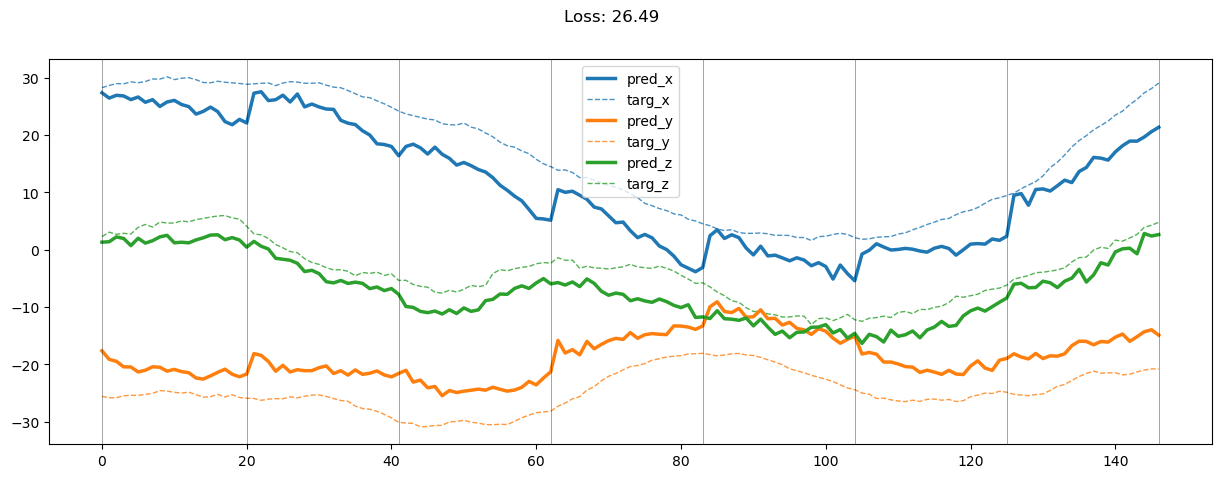

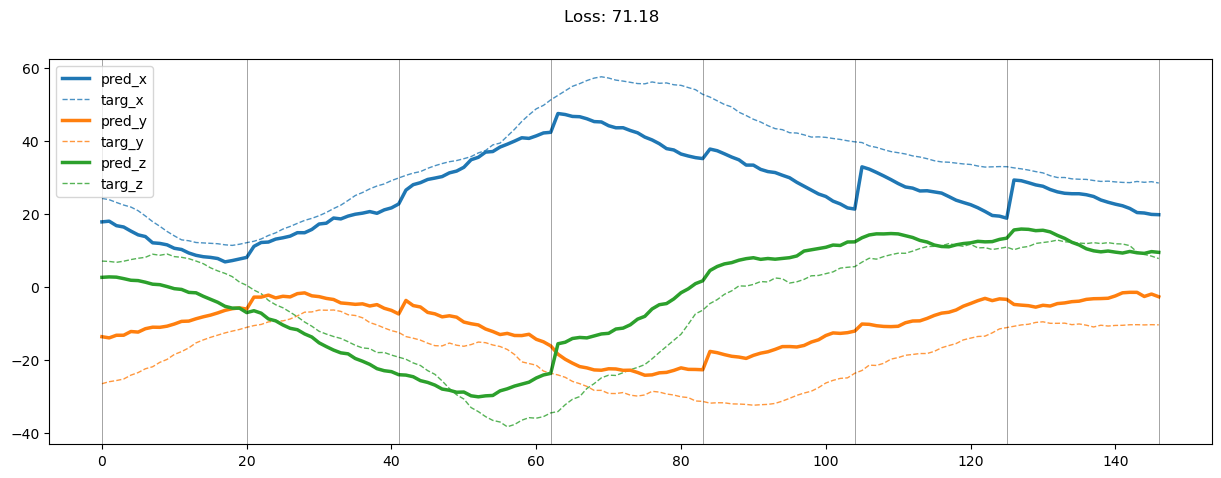

05199: train loss:  6.260, imu loss:  0.644, mag loss:  25.342, div loss:  5.616
       valid loss:  77.913, imu loss:  0.521, mag loss:  70.569, div loss:  77.392
05219: train loss:  6.390, imu loss:  0.623, mag loss:  26.360, div loss:  5.766
       valid loss:  87.815, imu loss:  0.521, mag loss:  72.351, div loss:  87.293
05239: train loss:  6.222, imu loss:  0.615, mag loss:  25.271, div loss:  5.606
       valid loss:  85.393, imu loss:  0.521, mag loss:  71.387, div loss:  84.871
05259: train loss:  6.233, imu loss:  0.604, mag loss:  25.231, div loss:  5.629
       valid loss:  90.590, imu loss:  0.521, mag loss:  74.619, div loss:  90.069
05279: train loss:  6.308, imu loss:  0.604, mag loss:  26.234, div loss:  5.703
       valid loss:  75.759, imu loss:  0.521, mag loss:  70.136, div loss:  75.237
05299: train loss:  5.812, imu loss:  0.615, mag loss:  25.803, div loss:  5.197
       valid loss:  69.588, imu loss:  0.521, mag loss:  68.436, div loss:  69.067
05319: train los

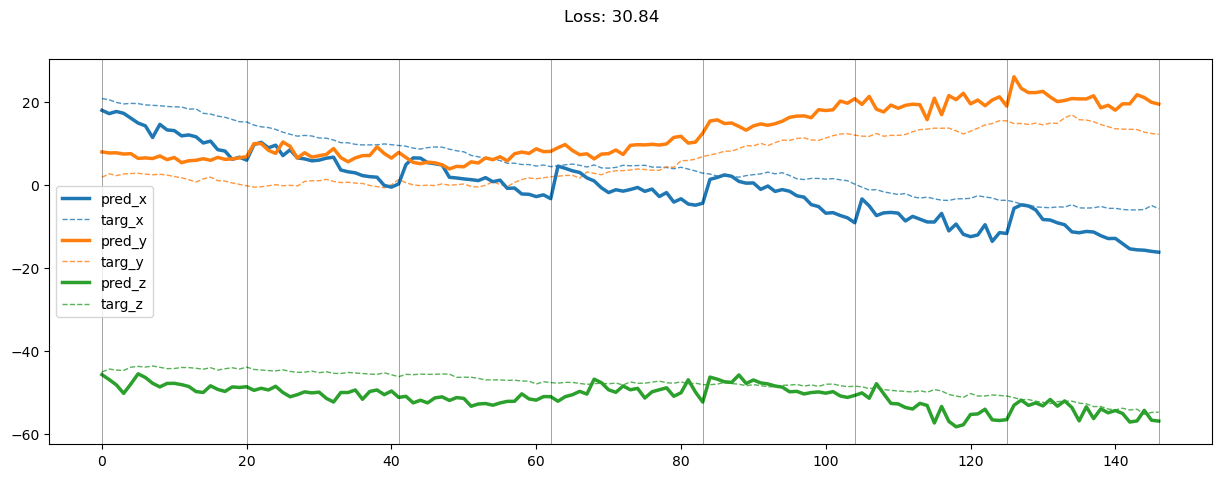

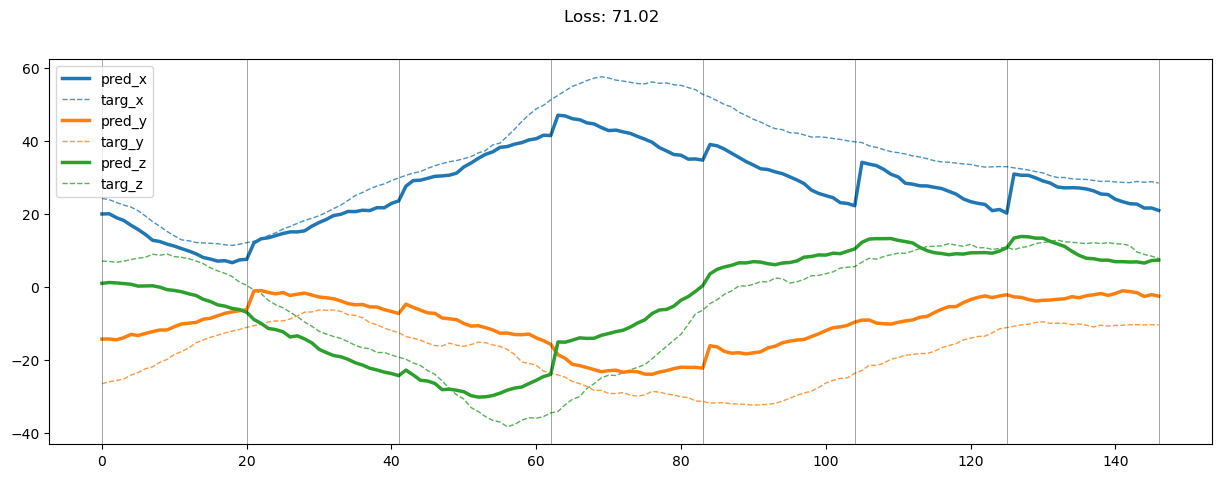

05399: train loss:  5.737, imu loss:  0.637, mag loss:  26.450, div loss:  5.100
       valid loss:  75.949, imu loss:  0.521, mag loss:  71.207, div loss:  75.428
05419: train loss:  6.009, imu loss:  0.614, mag loss:  24.804, div loss:  5.395
       valid loss:  73.080, imu loss:  0.521, mag loss:  67.366, div loss:  72.559
05439: train loss:  5.831, imu loss:  0.618, mag loss:  23.698, div loss:  5.213
       valid loss:  84.471, imu loss:  0.521, mag loss:  71.878, div loss:  83.950
05459: train loss:  5.828, imu loss:  0.619, mag loss:  24.783, div loss:  5.209
       valid loss:  88.845, imu loss:  0.521, mag loss:  75.599, div loss:  88.324
05479: train loss:  5.722, imu loss:  0.617, mag loss:  25.173, div loss:  5.106
       valid loss:  77.636, imu loss:  0.521, mag loss:  71.638, div loss:  77.115
05499: train loss:  5.737, imu loss:  0.638, mag loss:  24.704, div loss:  5.099
       valid loss:  72.759, imu loss:  0.521, mag loss:  67.987, div loss:  72.238
05519: train los

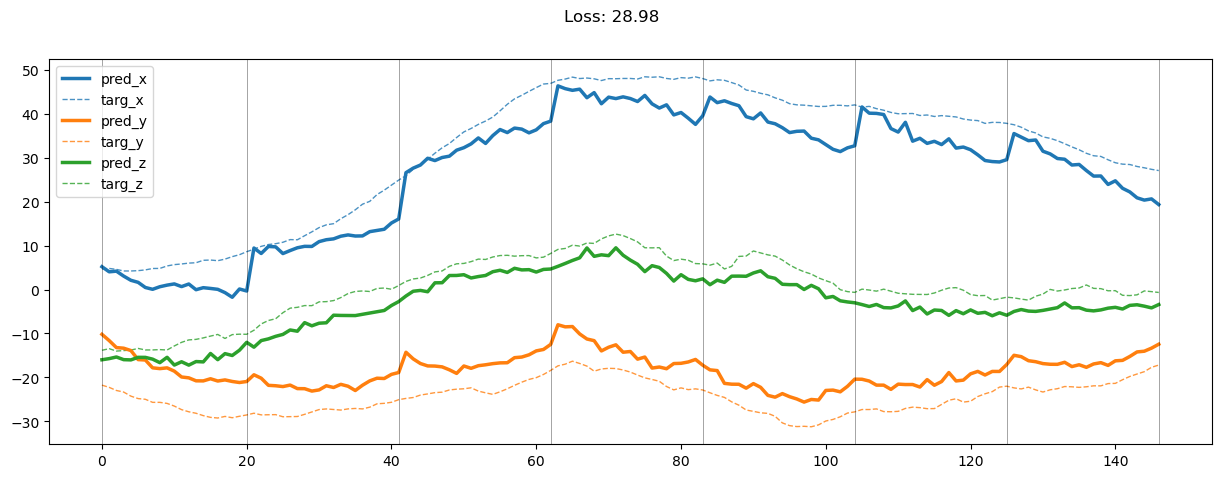

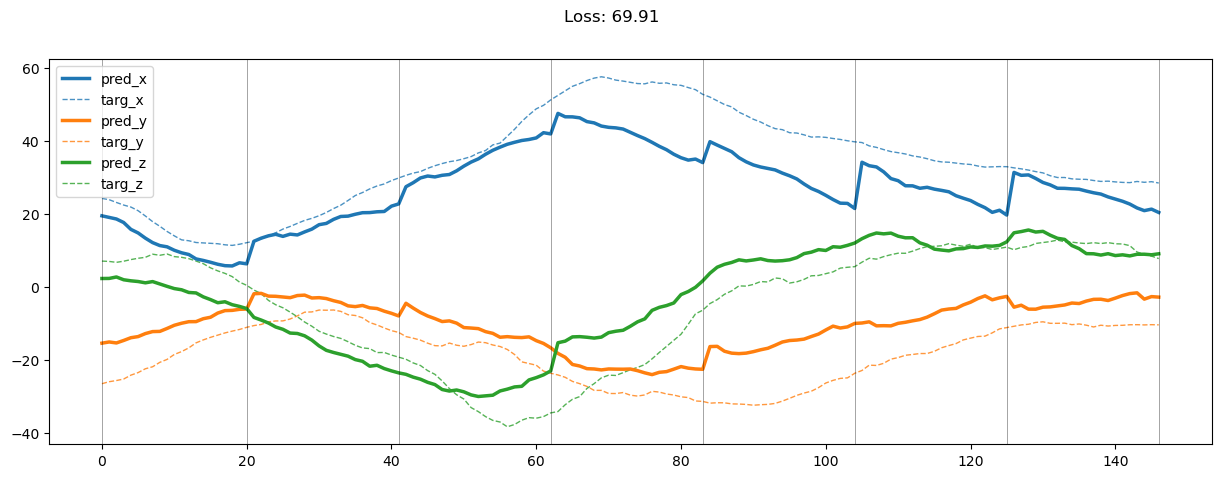

05599: train loss:  5.494, imu loss:  0.624, mag loss:  24.379, div loss:  4.870
       valid loss:  80.878, imu loss:  0.521, mag loss:  69.846, div loss:  80.357
05619: train loss:  5.594, imu loss:  0.609, mag loss:  24.361, div loss:  4.985
       valid loss:  82.683, imu loss:  0.521, mag loss:  70.135, div loss:  82.162
05639: train loss:  5.681, imu loss:  0.626, mag loss:  25.148, div loss:  5.054
       valid loss:  89.038, imu loss:  0.521, mag loss:  74.128, div loss:  88.517
05659: train loss:  5.529, imu loss:  0.633, mag loss:  24.506, div loss:  4.897
       valid loss:  99.768, imu loss:  0.521, mag loss:  76.360, div loss:  99.247
05679: train loss:  5.362, imu loss:  0.641, mag loss:  24.300, div loss:  4.721
       valid loss:  90.440, imu loss:  0.521, mag loss:  73.577, div loss:  89.919
05699: train loss:  5.353, imu loss:  0.600, mag loss:  25.956, div loss:  4.752
       valid loss:  82.027, imu loss:  0.521, mag loss:  71.509, div loss:  81.506
05719: train los

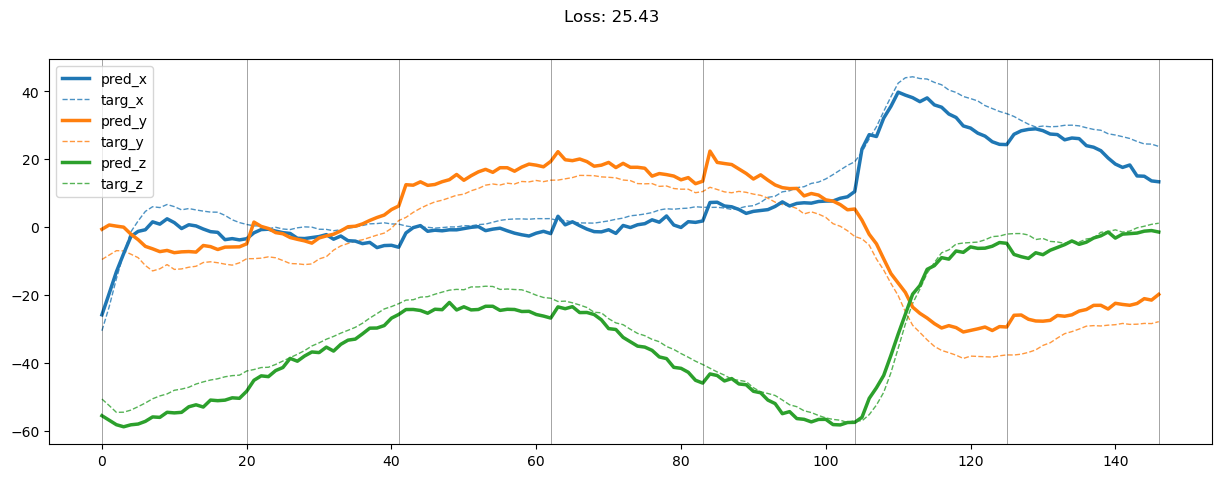

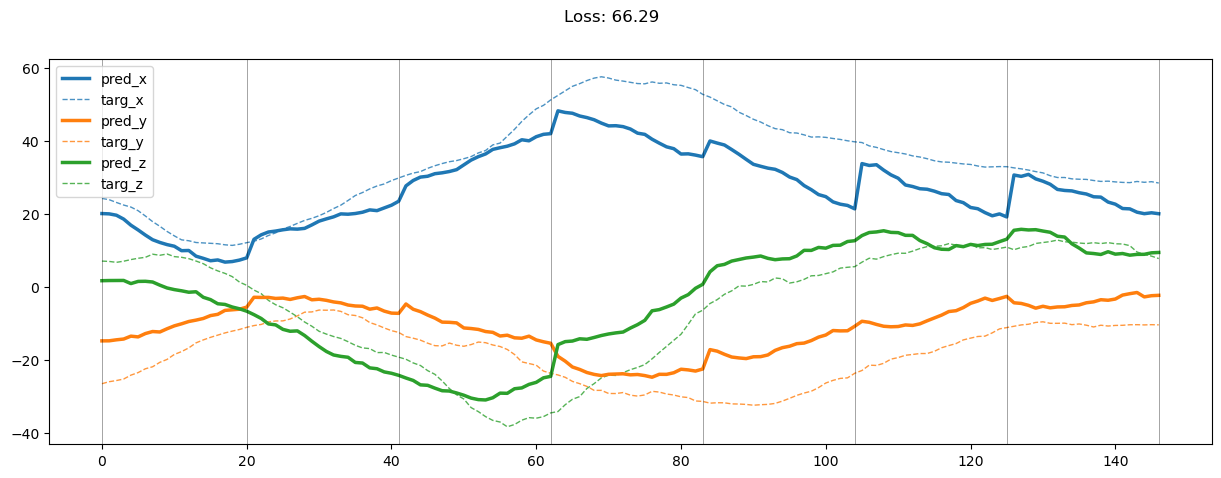

05799: train loss:  5.045, imu loss:  0.616, mag loss:  22.086, div loss:  4.429
       valid loss:  78.264, imu loss:  0.521, mag loss:  66.400, div loss:  77.743
05819: train loss:  5.166, imu loss:  0.627, mag loss:  23.053, div loss:  4.539
       valid loss:  65.816, imu loss:  0.521, mag loss:  61.447, div loss:  65.295
05839: train loss:  4.987, imu loss:  0.594, mag loss:  22.238, div loss:  4.393
       valid loss:  82.903, imu loss:  0.521, mag loss:  68.775, div loss:  82.382
05859: train loss:  4.891, imu loss:  0.619, mag loss:  21.951, div loss:  4.273
       valid loss:  83.751, imu loss:  0.521, mag loss:  70.661, div loss:  83.230
05879: train loss:  4.900, imu loss:  0.580, mag loss:  23.342, div loss:  4.320
       valid loss:  77.936, imu loss:  0.521, mag loss:  68.423, div loss:  77.415
05899: train loss:  4.781, imu loss:  0.629, mag loss:  22.954, div loss:  4.153
       valid loss:  71.661, imu loss:  0.521, mag loss:  65.002, div loss:  71.140
05919: train los

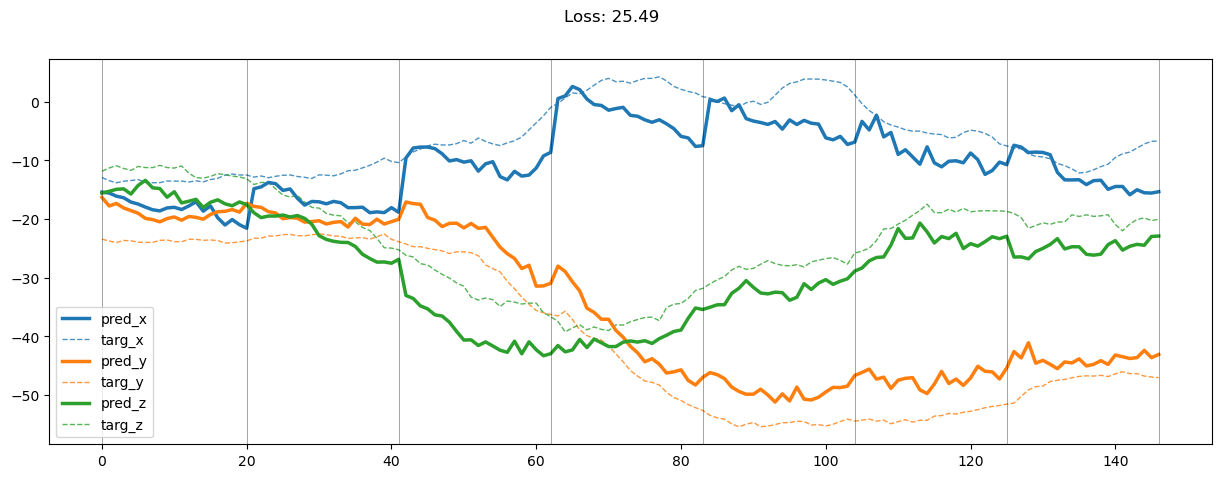

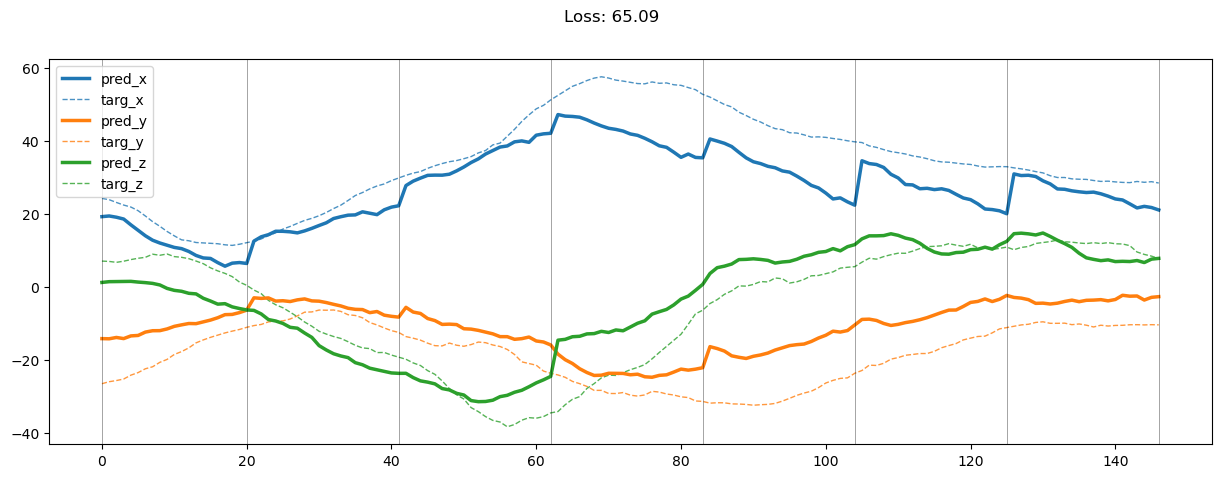

05999: train loss:  4.698, imu loss:  0.581, mag loss:  21.812, div loss:  4.117
       valid loss:  71.497, imu loss:  0.521, mag loss:  65.493, div loss:  70.976


In [28]:
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}')

In [1]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [ ]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::200]:
    plot_result(rs)

In [ ]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::50]:
    plot_result(rs)